# 1 Resumo do pedido


A rede de academias Model Fitness está desenvolvendo uma estratégia de interação com o cliente baseados em dados analíticos.

Um dos problemas mais comuns que academias e outros serviços enfrentam é a rotatividade de clientes. Como você sabe se um cliente não está mais com você? Você pode calcular a rotatividade baseado nas pessoas que se livram das suas contas ou não renovam seus contratos. No entanto, às vezes não é óbvio que um cliente saiu: eles podem sair de fininho.

Indicadores de rotatividade varia de área para área. Se um usuário compra de uma loja online raramente mas regularmente, você não pode dizer que é um fujão. Mas se por duas semanas eles não abriam o canal que é atualizado diariamente, essa é uma razão para se preocupar: seu seguidor pode ter ficado aborrecido e deixado você.

Para uma academia, faz sentido dizer que os clientes saíram se eles não aparecem há um mês. É claro, é possível que eles estejam em Cancun e virão tornar a frequentar quando retornarem, mas esse não é um caso comum. Normalmente, se um cliente ingressa, vem algumas vezes, depois desaparece, ele provavelmente não voltará.

Em vez de lutar com a rotatividade, Model Fitness digitalizou uma parte dos perfis dos clientes. Sua tarefa é analisá-los e vir com uma estratégia de retenção de clientes.

Você deve:

    Aprender a predizer a probabilidade de rotatividade (para o mês seguinte) para cada cliente
    Elabore retratos de usuários típicos: selecione os grupos mais marcantes e descreva suas principais características
    Analise os fatores que mais impactam a rotatividade
    Tire conclusões básicas e desenvolva recomendações sobre como melhorar o serviço de clientes:
    Identifique grupos alvo
    Sugira medidas para diminuir a rotatividade
    Descreva qualquer outro padrão que você vir com respeito às interações com clientes

# 1.1 Carregando bibliotecas necessárias

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

# 1.2 Carregando dados fornecidos

In [2]:
churn_data = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
churn_data

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
...      ...            ...      ...            ...    ...              ...   
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0                1   29                     14.227470                    5.0   
1                1   31                    113.202938                   12.0   
2                0   28                    129.448479                    1.0   
3                1   33                     62.669863                   12.0   
4                0   26                    198.362265                    1.0   
...            ...  ...                           ...                    ...   
3995             0   33                      2.406023                   12.0   
3996             1   29                     68.883764                    1.0   
3997             0   28                     78.250542                   11.0   
3998             0   32                     61.912657                    5.0   
3999             1   30                    178.861814                   12.0   

      Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0            3                   0.020398                           0.000000   
1            7                   1.922936                           1.910244   
2            2                   1.859098                           1.736502   
3            2                   3.205633                           3.357215   
4            3                   1.113884                           1.120078   
...        ...                        ...                                ...   
3995         8                   2.284497                           2.349070   
3996         1                   1.277168                           0.292859   
3997         2                   2.786146                           2.831439   
3998         3                   1.630108                           1.596237   
3999         1                   1.101832                           1.035270   

      Churn  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
3995      0  
3996      1  
3997      0  
3998      0  
3999      0  

[4000 rows x 14 columns]

# 2 Pré-processamento dos dados

Vou agora checar se os dados precisam ser processados. Checar possíveis problemas em cada coluna, valores ausentes e duplicatas, e processar os dados pra facilitar a análise adiante.

# 2.1 Análises Iniciais

In [4]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
churn_data.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
churn_data.duplicated().sum()

0

Resultados da análise inicial:
    
    1) As colunas estão todas em UpperCase. Vou modificar os nomes de todas pra letras minúsculas. 
    2) A coluna Month_to_end_contract está no tipo float e pode ser tipo int
    3) Não existem valores ausentes nem duplicatos

In [7]:
churn_data.columns = churn_data.columns.str.lower()
churn_data['month_to_end_contract'] = churn_data['month_to_end_contract'].astype(int)
churn_data

gender  near_location  partner  promo_friends  phone  contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
...      ...            ...      ...            ...    ...              ...   
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      group_visits  age  avg_additional_charges_total  month_to_end_contract  \
0                1   29                     14.227470                      5   
1                1   31                    113.202938                     12   
2                0   28                    129.448479                      1   
3                1   33                     62.669863                     12   
4                0   26                    198.362265                      1   
...            ...  ...                           ...                    ...   
3995             0   33                      2.406023                     12   
3996             1   29                     68.883764                      1   
3997             0   28                     78.250542                     11   
3998             0   32                     61.912657                      5   
3999             1   30                    178.861814                     12   

      lifetime  avg_class_frequency_total  avg_class_frequency_current_month  \
0            3                   0.020398                           0.000000   
1            7                   1.922936                           1.910244   
2            2                   1.859098                           1.736502   
3            2                   3.205633                           3.357215   
4            3                   1.113884                           1.120078   
...        ...                        ...                                ...   
3995         8                   2.284497                           2.349070   
3996         1                   1.277168                           0.292859   
3997         2                   2.786146                           2.831439   
3998         3                   1.630108                           1.596237   
3999         1                   1.101832                           1.035270   

      churn  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
3995      0  
3996      1  
3997      0  
3998      0  
3999      0  

[4000 rows x 14 columns]

# 2.2 Checando valores estatísticos

In [8]:
churn_data.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Podemos obter algumas informações relevantes quando analisamos os dados estatísticos do dataset:

    - A média da idade dos clientes é de 29 anos, com o minímo sendo 18 e o máximo 41.
    - 50% dos contratos tem duração de 1 mês, e 75% dos contratos tem duração de até 6 meses, o que mostra que o plano anual não é tão popular assim
    - Por isso, as estatísticas do tempo até o fim do contrato são parecidas, pois grande parte dos contratos são mensais.
    - A taxa de visitas dos clientes é em média aproximadamente 2 por semana, no entanto, existem clientes muito assíduos que foram 6 vezes em uma semana.
    - Os gastos extras na academia podem ser muito baixos, mas a média fica em torno de $147
    
    

# 2.3 Checando médias dos grupos de assinantes e cancelados

Se dividirmos os nossos clientes em dois grupos (clientes que cancelaram a assinatura e clientes que se mantém ativos) e analisamos as médias de cada característica de cada grupo, podemos identificar quais fatores estão relacionados com a permanência de um cliente ou com o cancelamento.

In [9]:
churn_select = churn_data.groupby('churn').mean()
churn_select

gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       contract_period  group_visits        age  avg_additional_charges_total  \
churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       avg_class_frequency_current_month  
churn                                     
0                               2.027882  
1                               1.044546

Novamente podemos identificar diversos fatores que se relacionam com os clientes que cancelaram sua assinatura. 0 são os clientes que não cancelaram e 1 são os que cancelaram.
    
    - Os clientes remanescentes moram mais próximos à academia
    - A média de clientes que possuem uma parceria empresarial é maior para os clientes que não cancelaram
    - Identificamos um fator importante no período do contrato: a média dos clientes que permaneceram é de quase 6 meses, enquanto dos que cancelaram é de quase 2 meses. Isso aponta que clientes que fazem contrato semestral possuem uma maior tendência à se manter na academia.
    - O que implica também que esses clientes que permanecem possuem mais meses restantes até o fim dos seus contratos, por isso a média também é maior para o grupo que permanece, e também explica a maior média de lifetime
    - A média dos assinantes é maior também na presença na academia do que dos que cancelaram
    - Outros fatores estão relacionados também aos clientes que não cancelaram suas assinaturas, como indicados com promoções de amigos e atividades em grupo.

# 2.4 Visualizando as características e suas correlações

Para uma melhor visibilidade das características, vamos montar alguns gráficos para comparar algumas informações. 

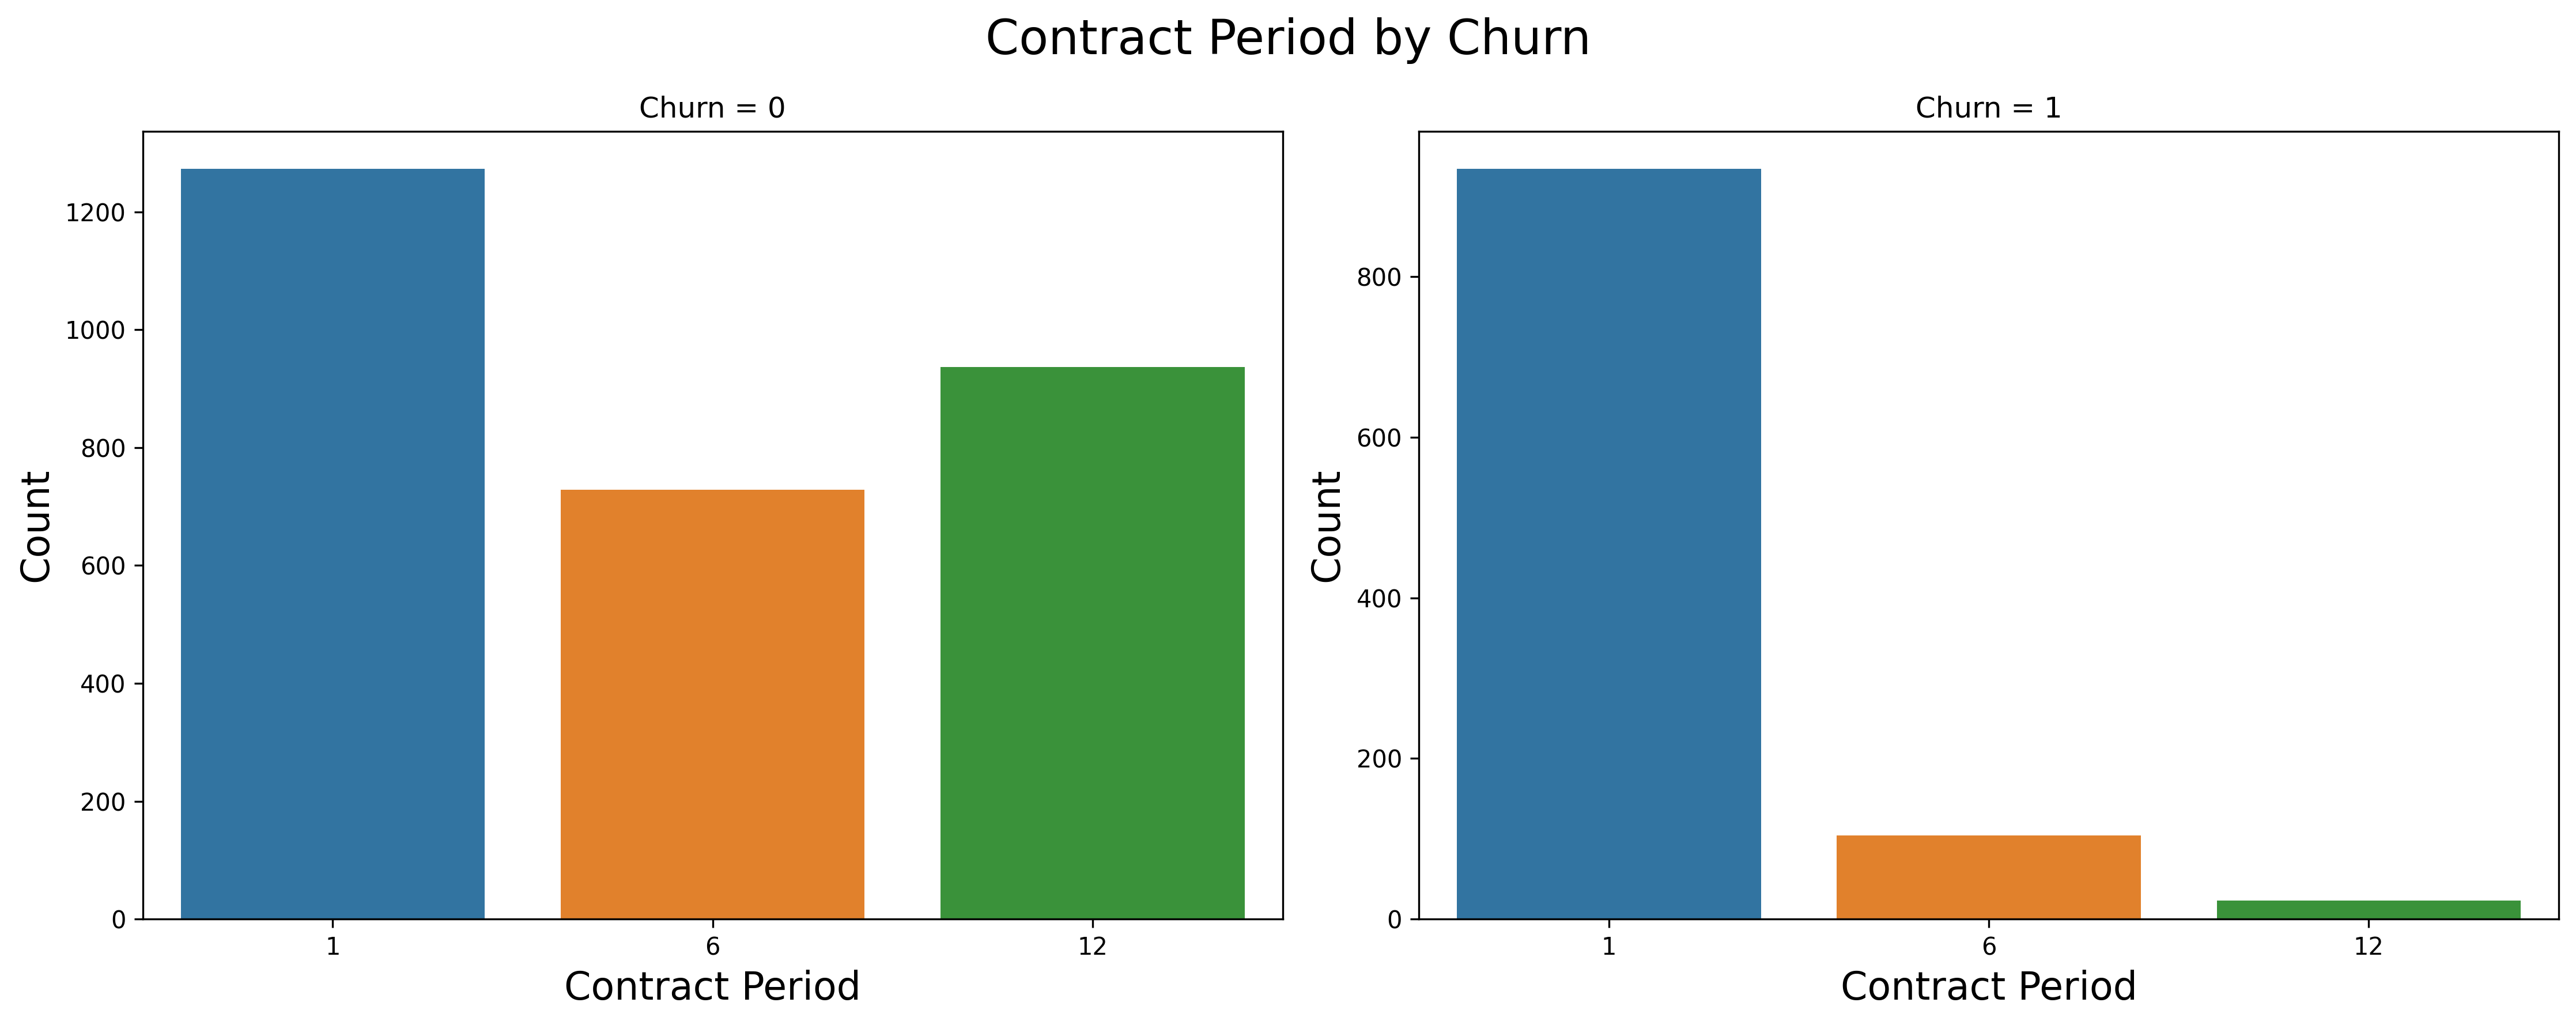

In [10]:
contract = ['contract_period', 'churn']
contracts_data = churn_data[contract]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), dpi=300)

sns.countplot(x='contract_period', data=contracts_data[contracts_data['churn'] == 0], ax=axes[0])
axes[0].set_title('Churn = 0')


sns.countplot(x='contract_period', data=contracts_data[contracts_data['churn'] == 1], ax=axes[1])
axes[1].set_title('Churn = 1')


for ax in axes:
    ax.set_ylabel('Count', fontsize = 16)
    ax.set_xlabel('Contract Period', fontsize = 16)
fig.suptitle('Contract Period by Churn', fontsize = 20)
plt.tight_layout()
plt.show()

Visualizando que, quanto maior o período do contrato, menor a chance de cancelamento da assinatura.

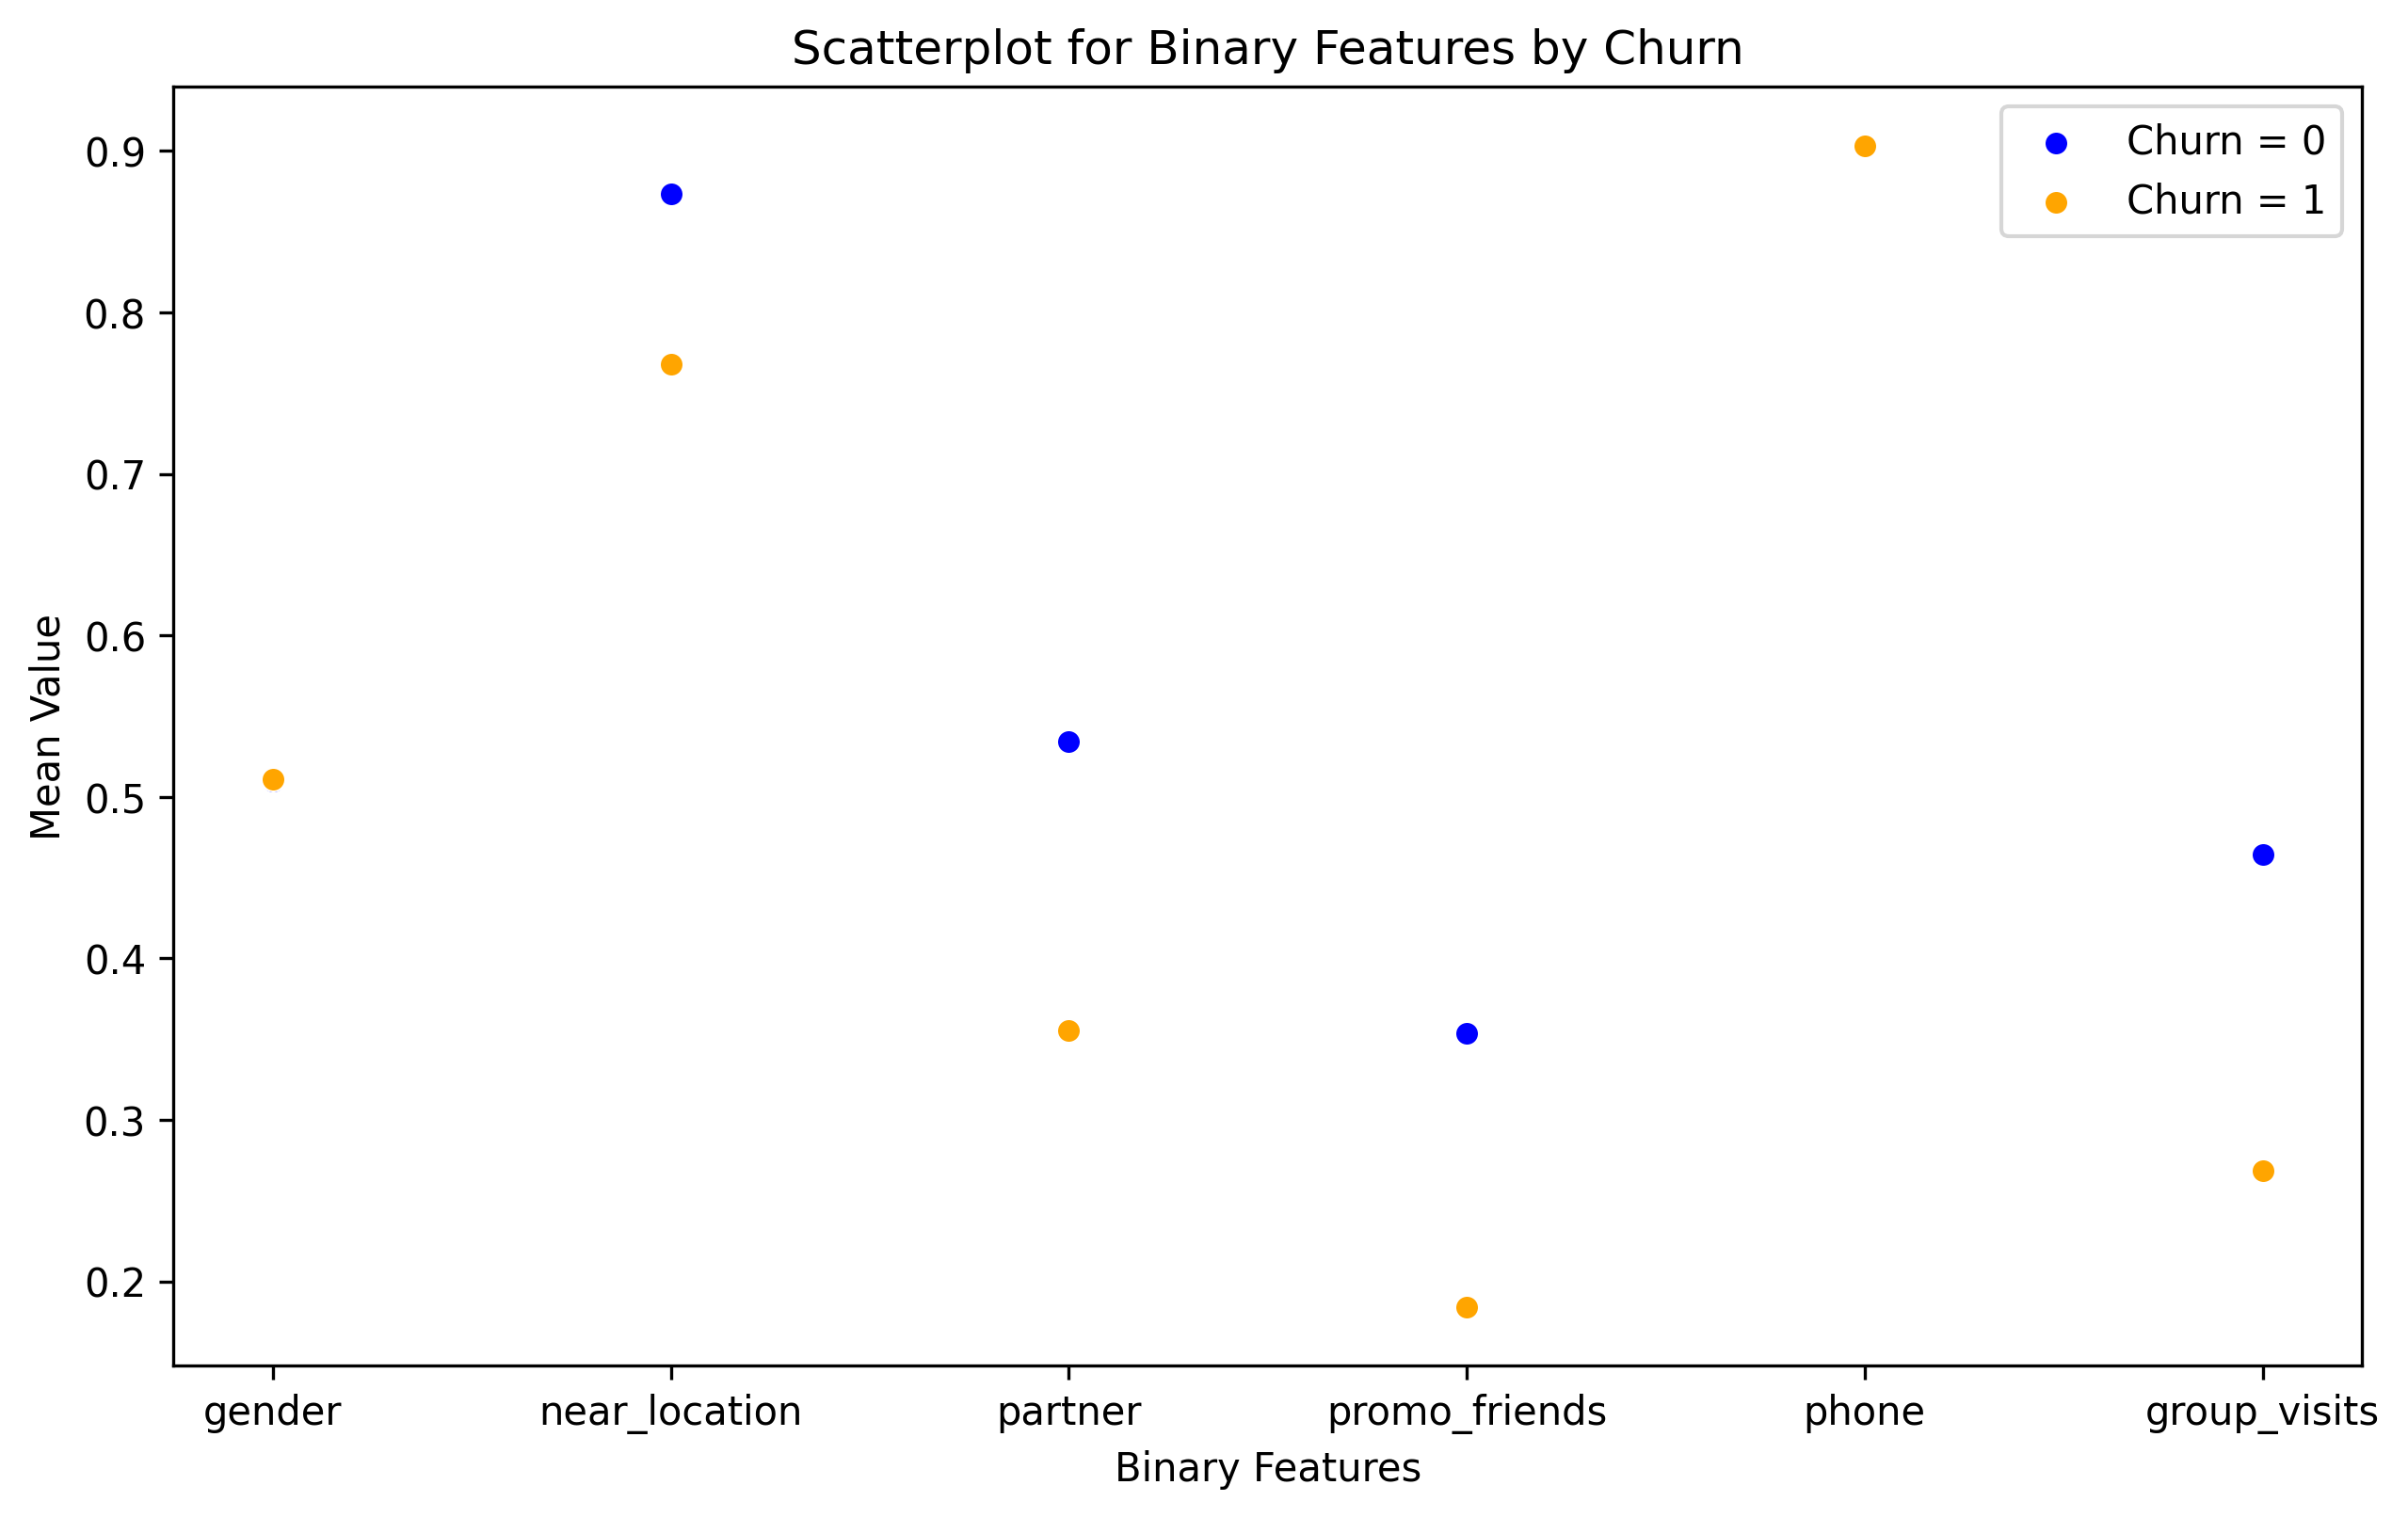

In [11]:
binary_columns = ["gender", "near_location", "partner", "promo_friends", "phone", "group_visits"]
binary_data = churn_select[binary_columns].transpose()

plt.figure(figsize=(10, 6), dpi = 300)
sns.scatterplot(data=binary_data, x=binary_columns, y=0, label='Churn = 0', color='blue')
sns.scatterplot(data=binary_data, x=binary_columns, y=1, label='Churn = 1', color='orange')

plt.xlabel('Binary Features')
plt.ylabel('Mean Value')
plt.title('Scatterplot for Binary Features by Churn')
plt.legend()
plt.show()

Diversas características impactaram positivamente o cliente para que ele decidisse não cancelar nesse mês, como proximidade da academia, parceria, promoção e atividades em grupo. Características como gênero do cliente e número de telefone se apresentaram irrelevantes, pois não existe diferença significativa entre a decisão de cancelamento e esses atributos.

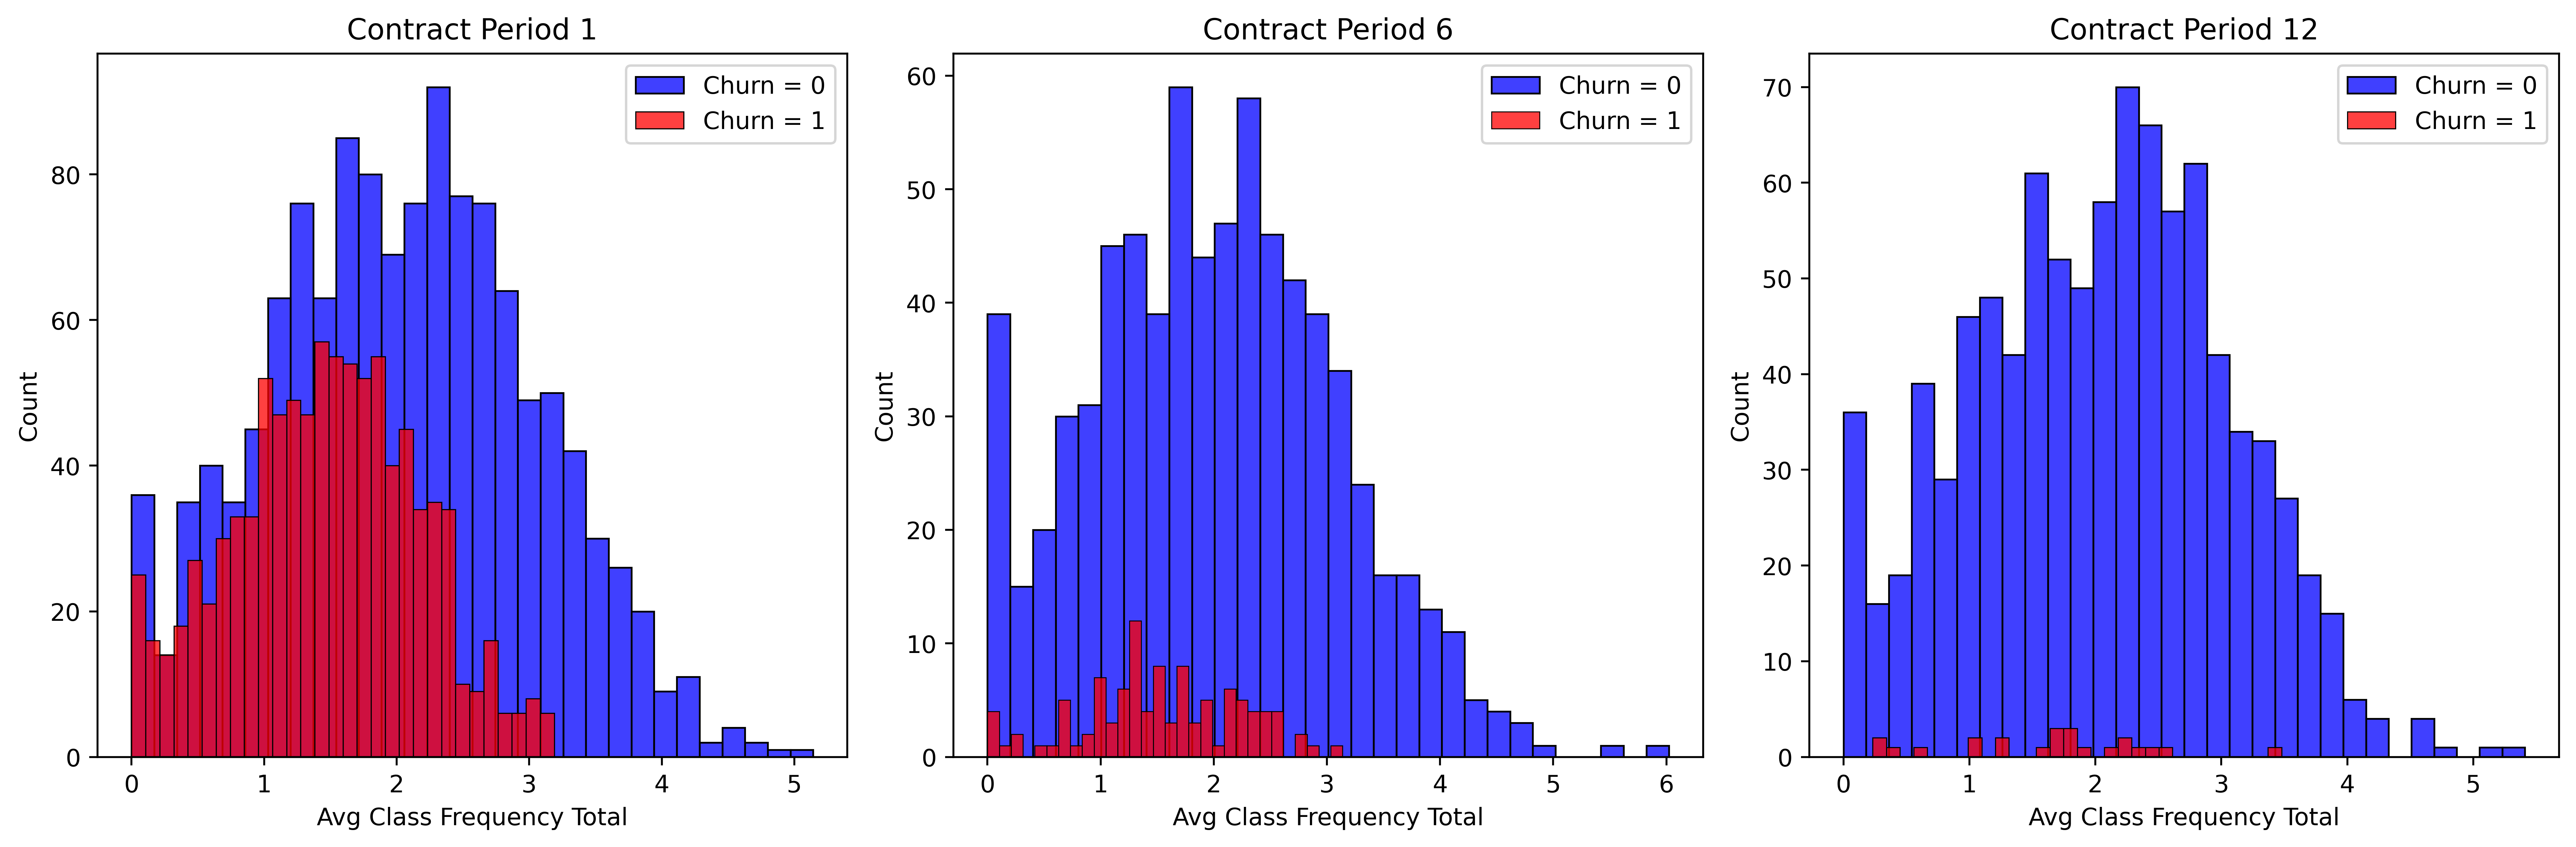

In [12]:
frequency_contract = ['avg_class_frequency_total', 'contract_period', 'churn']
frequency_data = churn_data[frequency_contract]
contract_values = [1, 6, 12]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=500)

for i, contract_value in enumerate(contract_values):
    sub_churn = frequency_data[frequency_data['contract_period'] == contract_value]
    
    sns.histplot(data=sub_churn[sub_churn['churn'] == 0], x='avg_class_frequency_total', ax=axes[i], bins=30, color='blue', label='Churn = 0')
    sns.histplot(data=sub_churn[sub_churn['churn'] == 1], x='avg_class_frequency_total', ax=axes[i], bins=30, color='red', label='Churn = 1')
    
    axes[i].set_title(f'Contract Period {contract_value}')
    axes[i].set_xlabel('Avg Class Frequency Total')
    axes[i].legend()

plt.tight_layout()
plt.show()

   Ao analisar a frequência média dos clientes nas suas visitas à academia, podemos notar que os clientes mais assíduos sempre possuem contratos mais longos. Além disso, no primeiro mês estão concentrados grande parte dos clientes que rescindiram seus contratos. 
   
A distribuição de frequência na academia mostra também que a taxa de cancelamentos das assinaturas impacta pouco no cenário geral dos contratos à longo prazo, e mostra que um dos pontos que a academia pode focar é justamente a assinatura semestral ou anual, já que existe uma quantidade imensa de clientes que não cancelam seus contratos qem um período contratual maior.

Outros tipos de visualizações podem ser feitas e analisadas dependendo da necessidade.

# 2.5 Matriz de Correlação

Como disse anteriomente, alguns valores não apresentaram relevância para o estudo. Algumas características não são parâmetros eficientes para predizer se um cliente vai ou não continuar com sua assinatura, como é o caso de "gender" e "phone". 
Vou remover essas características do dataset e trabalhar com as relevantes.

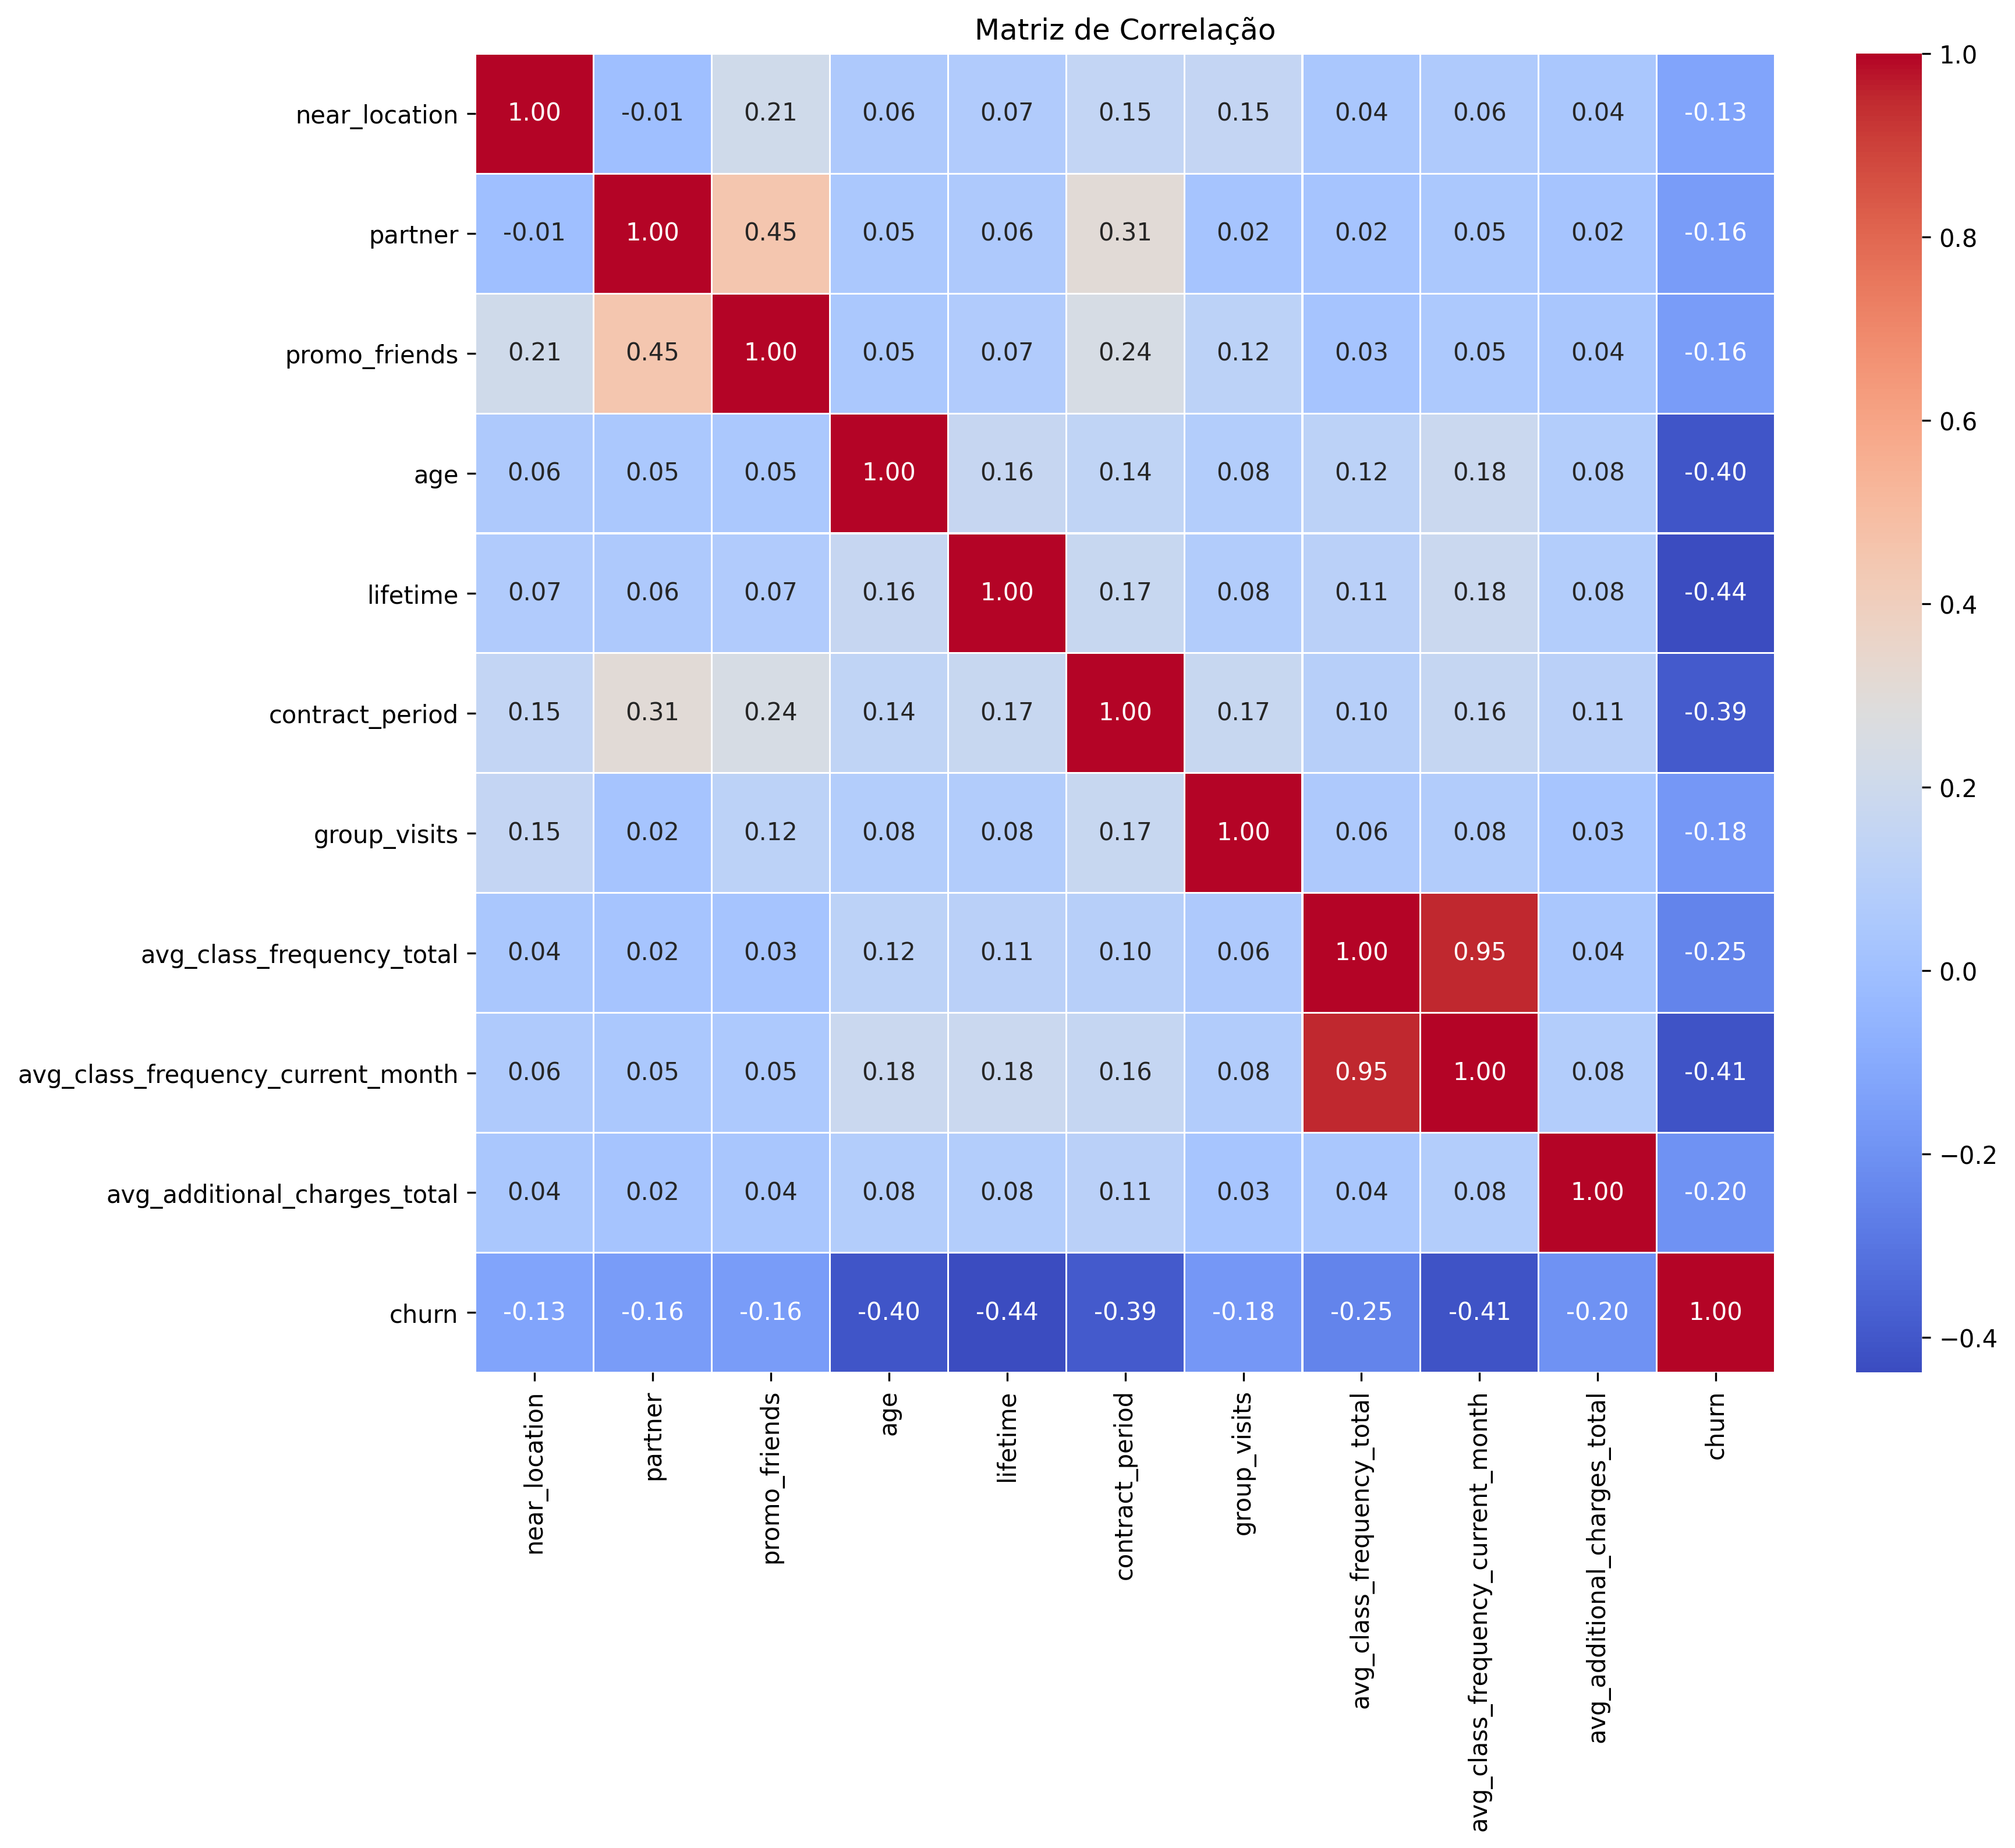

In [13]:
correlation = ['near_location', 'partner', 'promo_friends', 'age', 'lifetime', 'contract_period', 'group_visits', 'avg_class_frequency_total',
                        'avg_class_frequency_current_month', 'avg_additional_charges_total', 'churn']
correlation_data = churn_data[correlation]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(12, 10), dpi = 300)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

# 3 Aprendizado de Máquina

Vou agora implementar o treinamento de máquina para predizer a rotatividade dos clientes para o mês seguinte.

# 3.1 Modelo pra predizer rotatividade de clientes (Regressão Logística)

Vou agora criar o modelo de treinamento pra predizer se um cliente vai ou não cancelar sua assinatura. 

Vou aplicar dois algoritmos: regressão logística e Random Forest

Após aplicados, vou analisar as métricas de acurácia, precisão, sensibilidade, Score F1 e Roc_auc.

Como eu vou comparar os algoritmos entre si pra discernir qual o mais eficaz, eu vou fazer todas as análises e interpretações no final dos testes.

# 3.1.1 Regressão Logística Padrão

In [14]:
X = churn_data.drop(['churn'], axis = 1)
y = churn_data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression(max_iter=1000, class_weight = 'balanced')

model.fit(X_train, y_train)

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

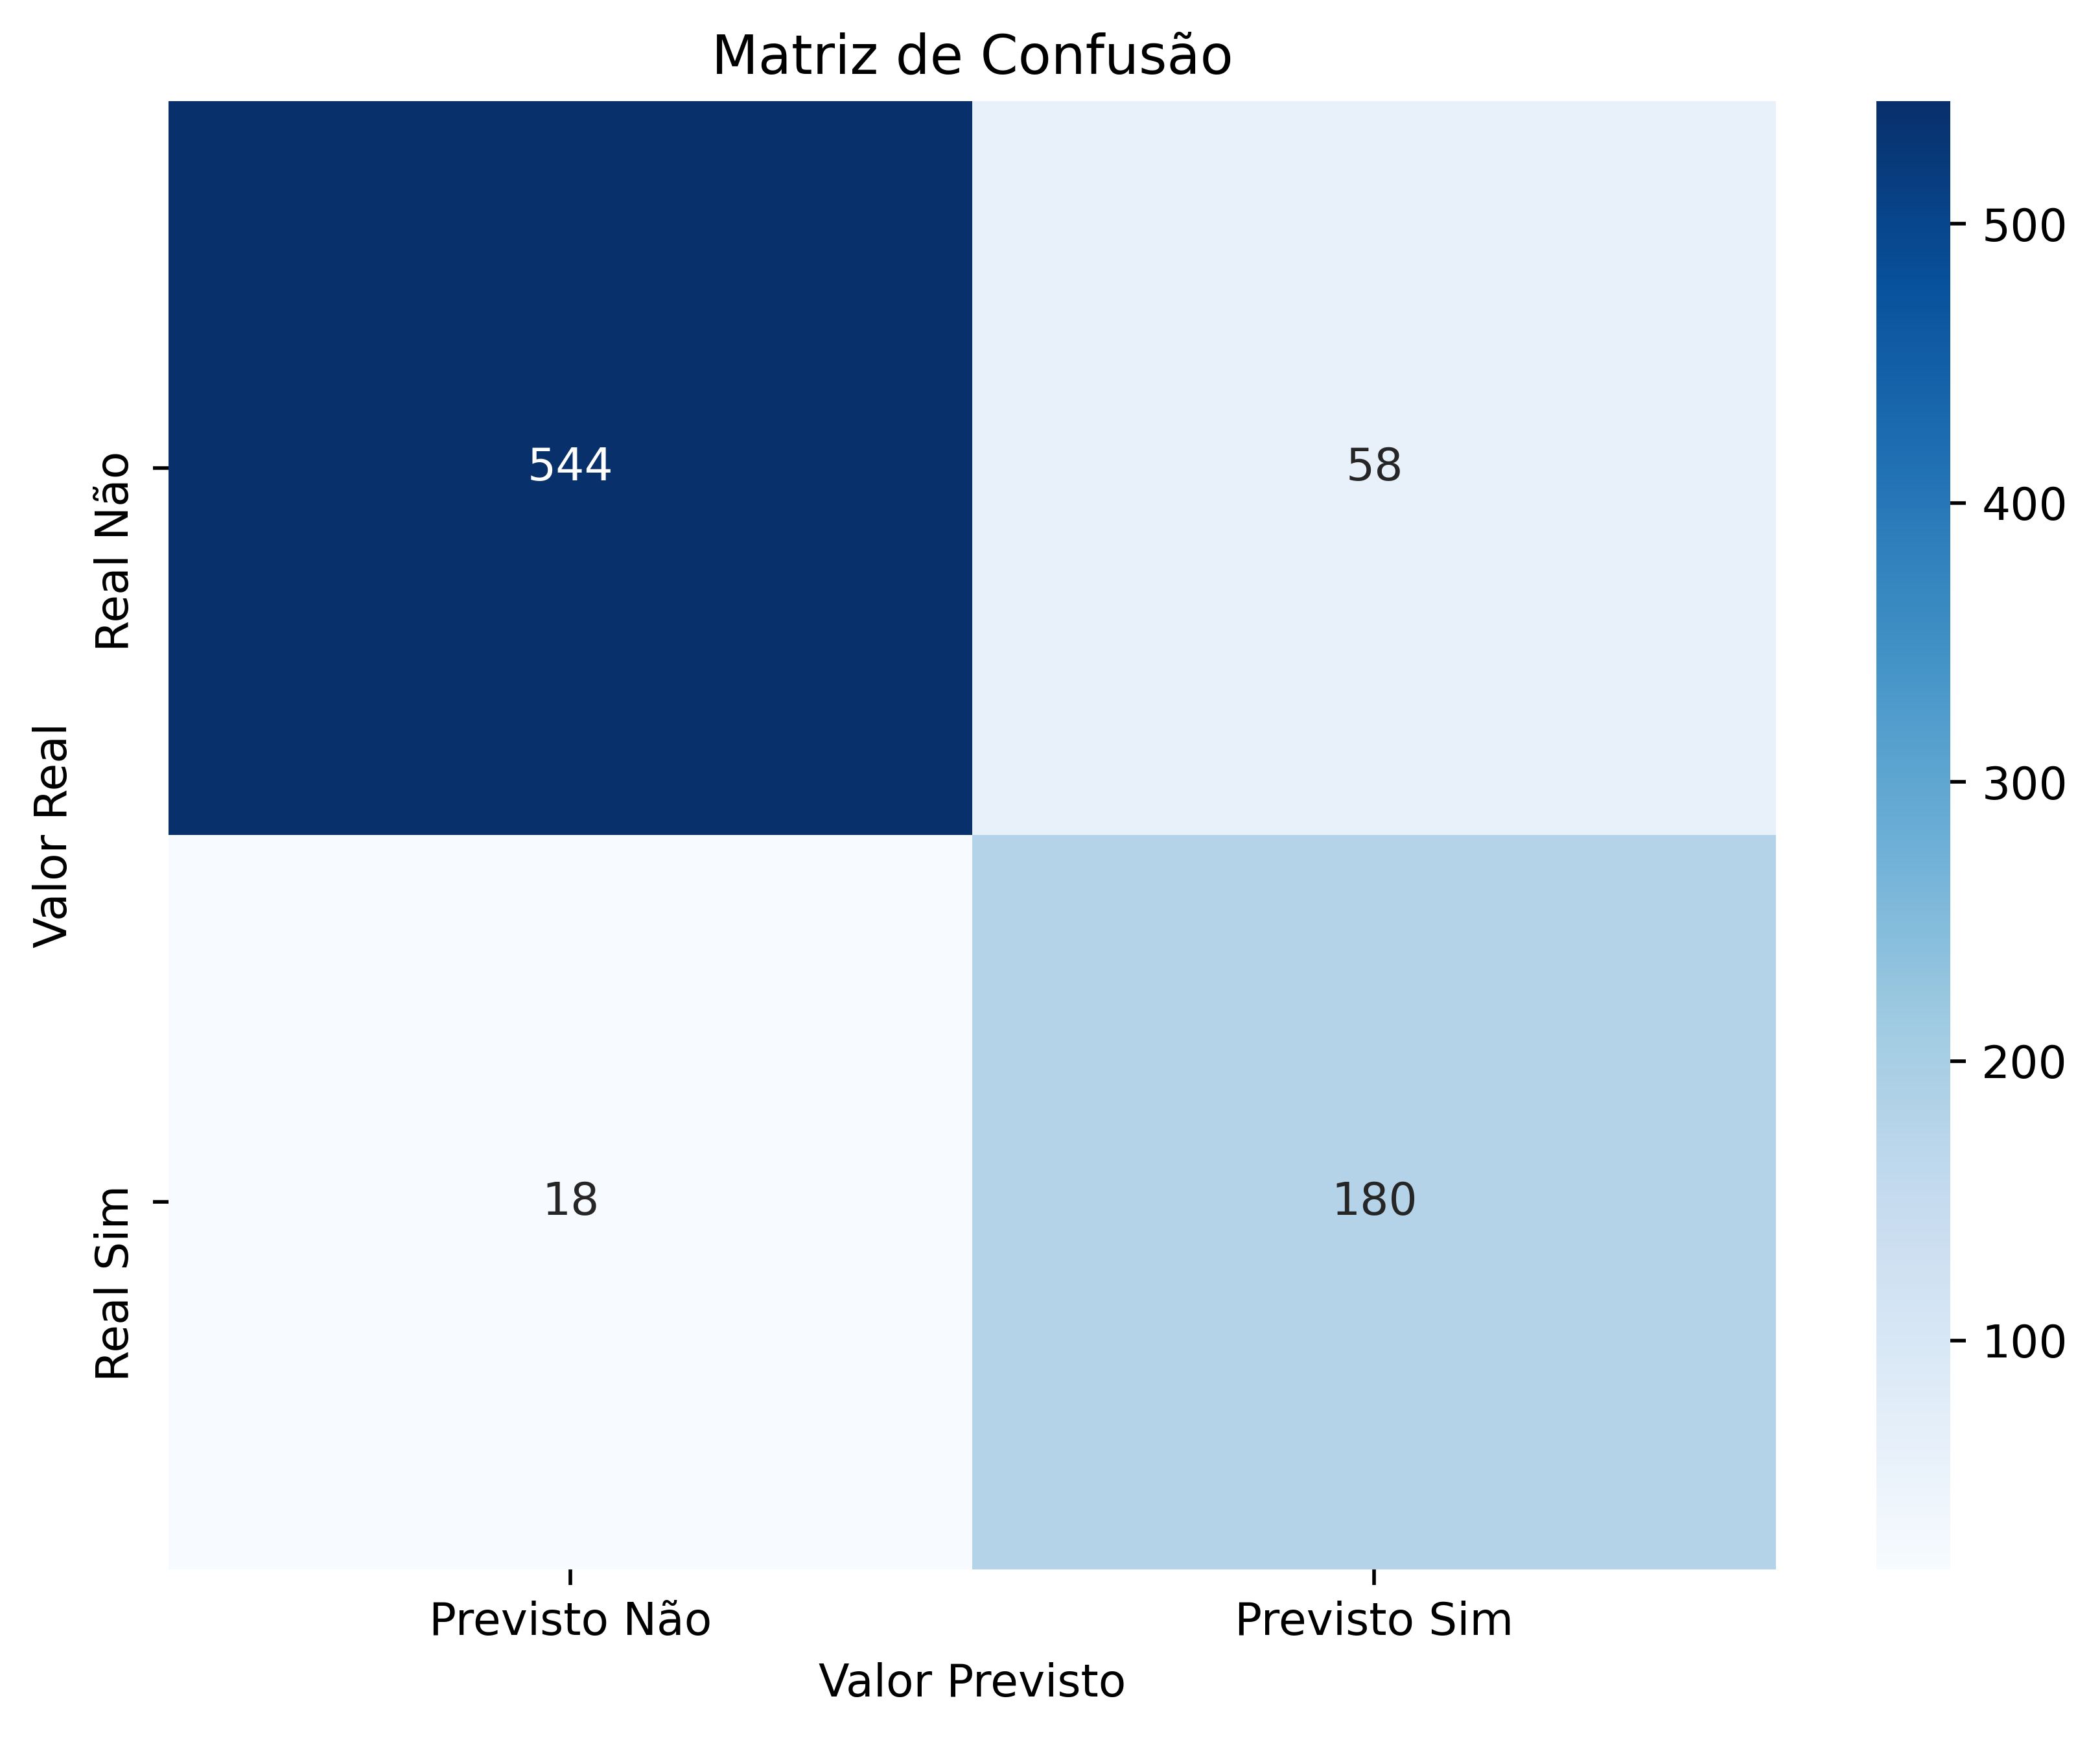

In [15]:
cm = confusion_matrix(y_test, predictions)
NV, PF, NF, PV = cm.ravel() 

plt.figure(figsize=(8, 6), dpi=500)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# 3.1.2 Regressão Logística Padronizada

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced', random_state = 0)
model.fit(X_train_st, y_train)

predictions_st = model.predict(X_test_st)
probabilities_st = model.predict_proba(X_test_st)[:,1]

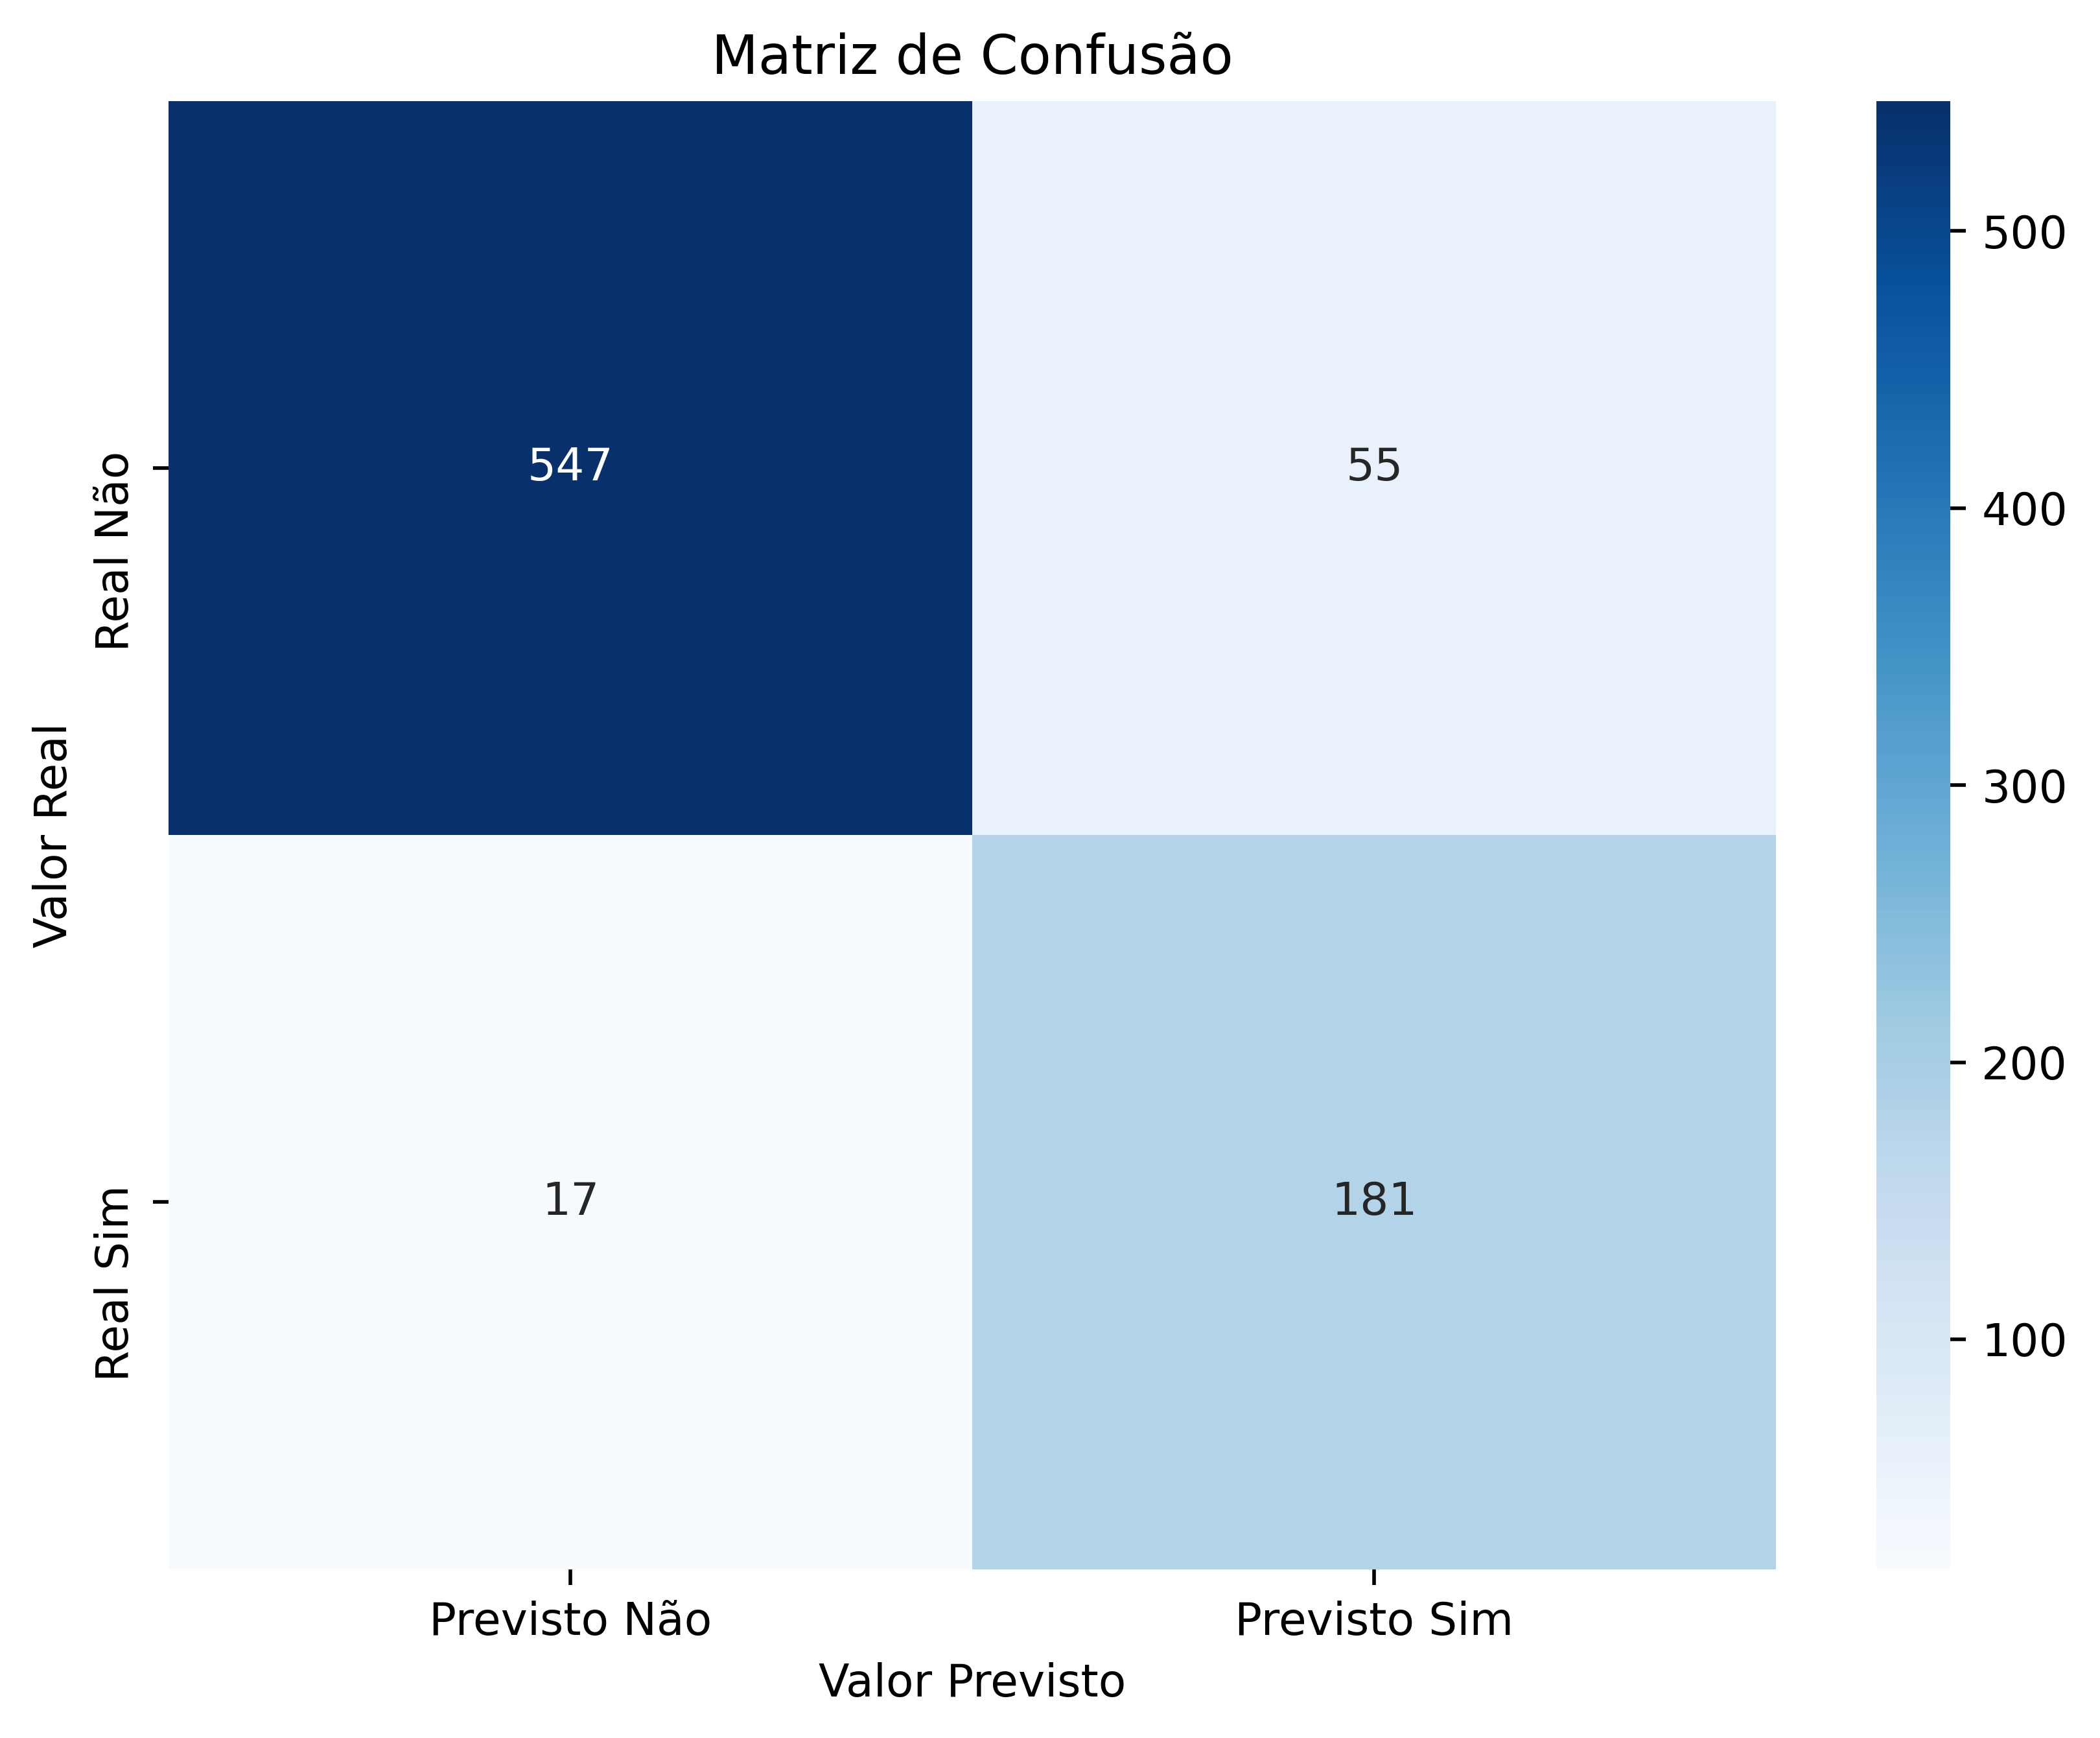

In [17]:
cm_st = confusion_matrix(y_test, predictions_st)
NV, PF, NF, PV = cm_st.ravel() 

plt.figure(figsize=(8, 6), dpi=500)
sns.heatmap(cm_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# 3.1.3 Analisando a Matriz Confusão e as métricas

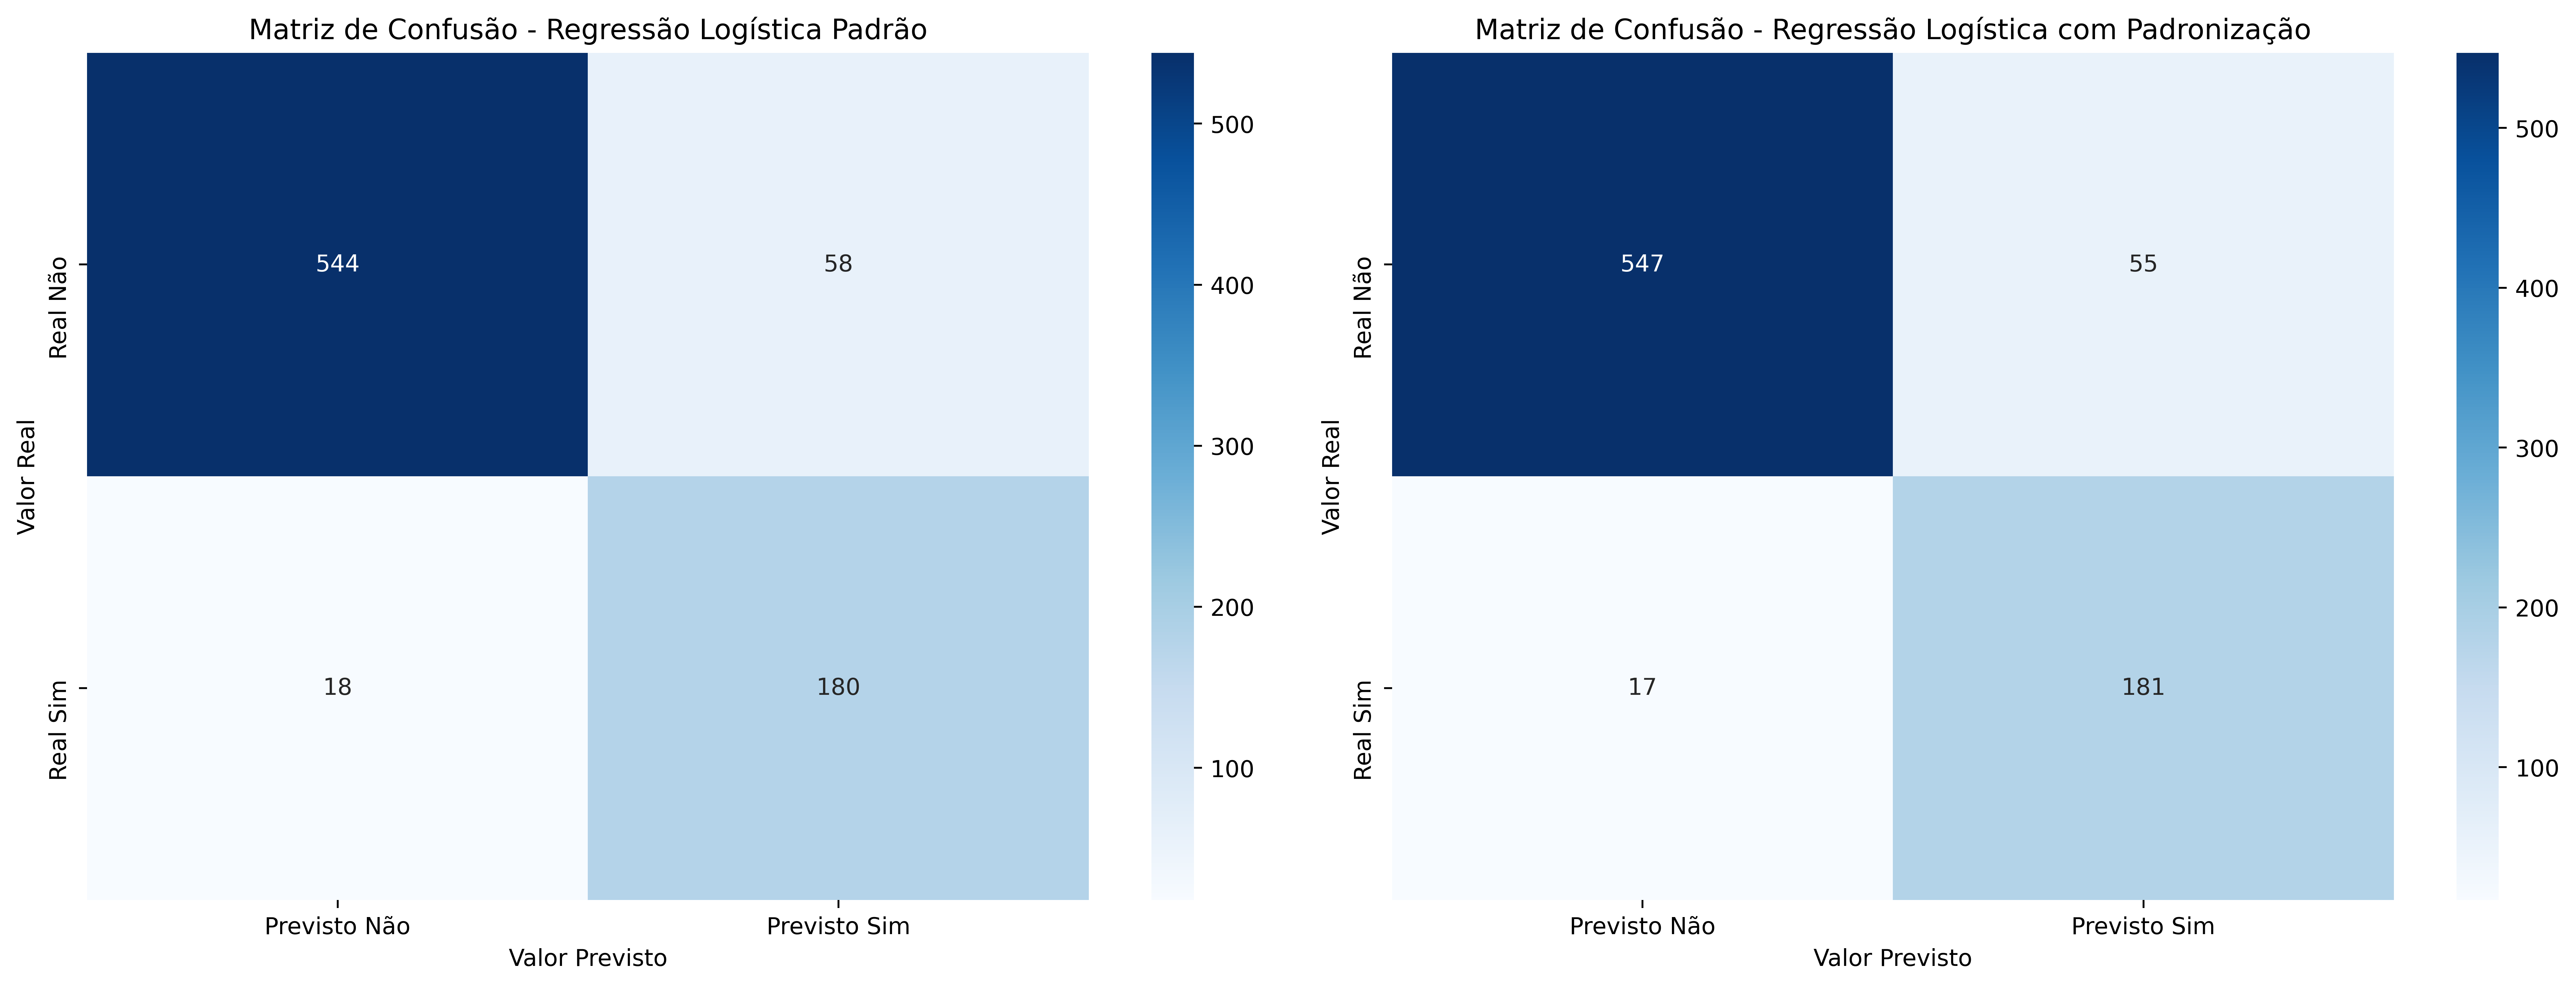

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=500)

sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[0])
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Previsto')
axes[0].set_title('Matriz de Confusão - Regressão Logística Padrão')

sns.heatmap(cm_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[1])
axes[1].set_ylabel('Valor Real')
axes[1].set_xlabel('Valor Previsto')
axes[1].set_title('Matriz de Confusão - Regressão Logística com Padronização')

plt.tight_layout()
plt.show()

In [19]:
print('Proporção entre as classes:\n',churn_data['churn'].value_counts())
print('\n')
print('Métricas para a previsão com regressão logistica')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))
print('\n')
threshold = 0.4
custom_predictions = [0 if i<threshold else 1 for i in probabilities]
print('Métricas para a previsão com limiar personalizado')
print('Acurácia para personalizado: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precisão para personalizado: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Sensibilidade para personalizado: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 para personalizado: {:.2f}'.format(f1_score(y_test, custom_predictions)))
print('\n')
print('Métricas para a previsão de regressão logística utilizando padronização')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions_st)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions_st)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions_st)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_st)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_st)))

Proporção entre as classes:
 0    2939
1    1061
Name: churn, dtype: int64


Métricas para a previsão com regressão logistica
Acurácia: 0.91
Precisão: 0.76
Sensibilidade: 0.91
F1: 0.83
ROC_AUC: 0.97


Métricas para a previsão com limiar personalizado
Acurácia para personalizado: 0.89
Precisão para personalizado: 0.72
Sensibilidade para personalizado: 0.94
F1 para personalizado: 0.81


Métricas para a previsão de regressão logística utilizando padronização
Acurácia: 0.91
Precisão: 0.77
Sensibilidade: 0.91
F1: 0.83
ROC_AUC: 0.97


# 3.2 Modelo pra predizer rotatividade de clientes (Random Forest)

# 3.2.1 Random Forest

In [20]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight = 'balanced')
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]


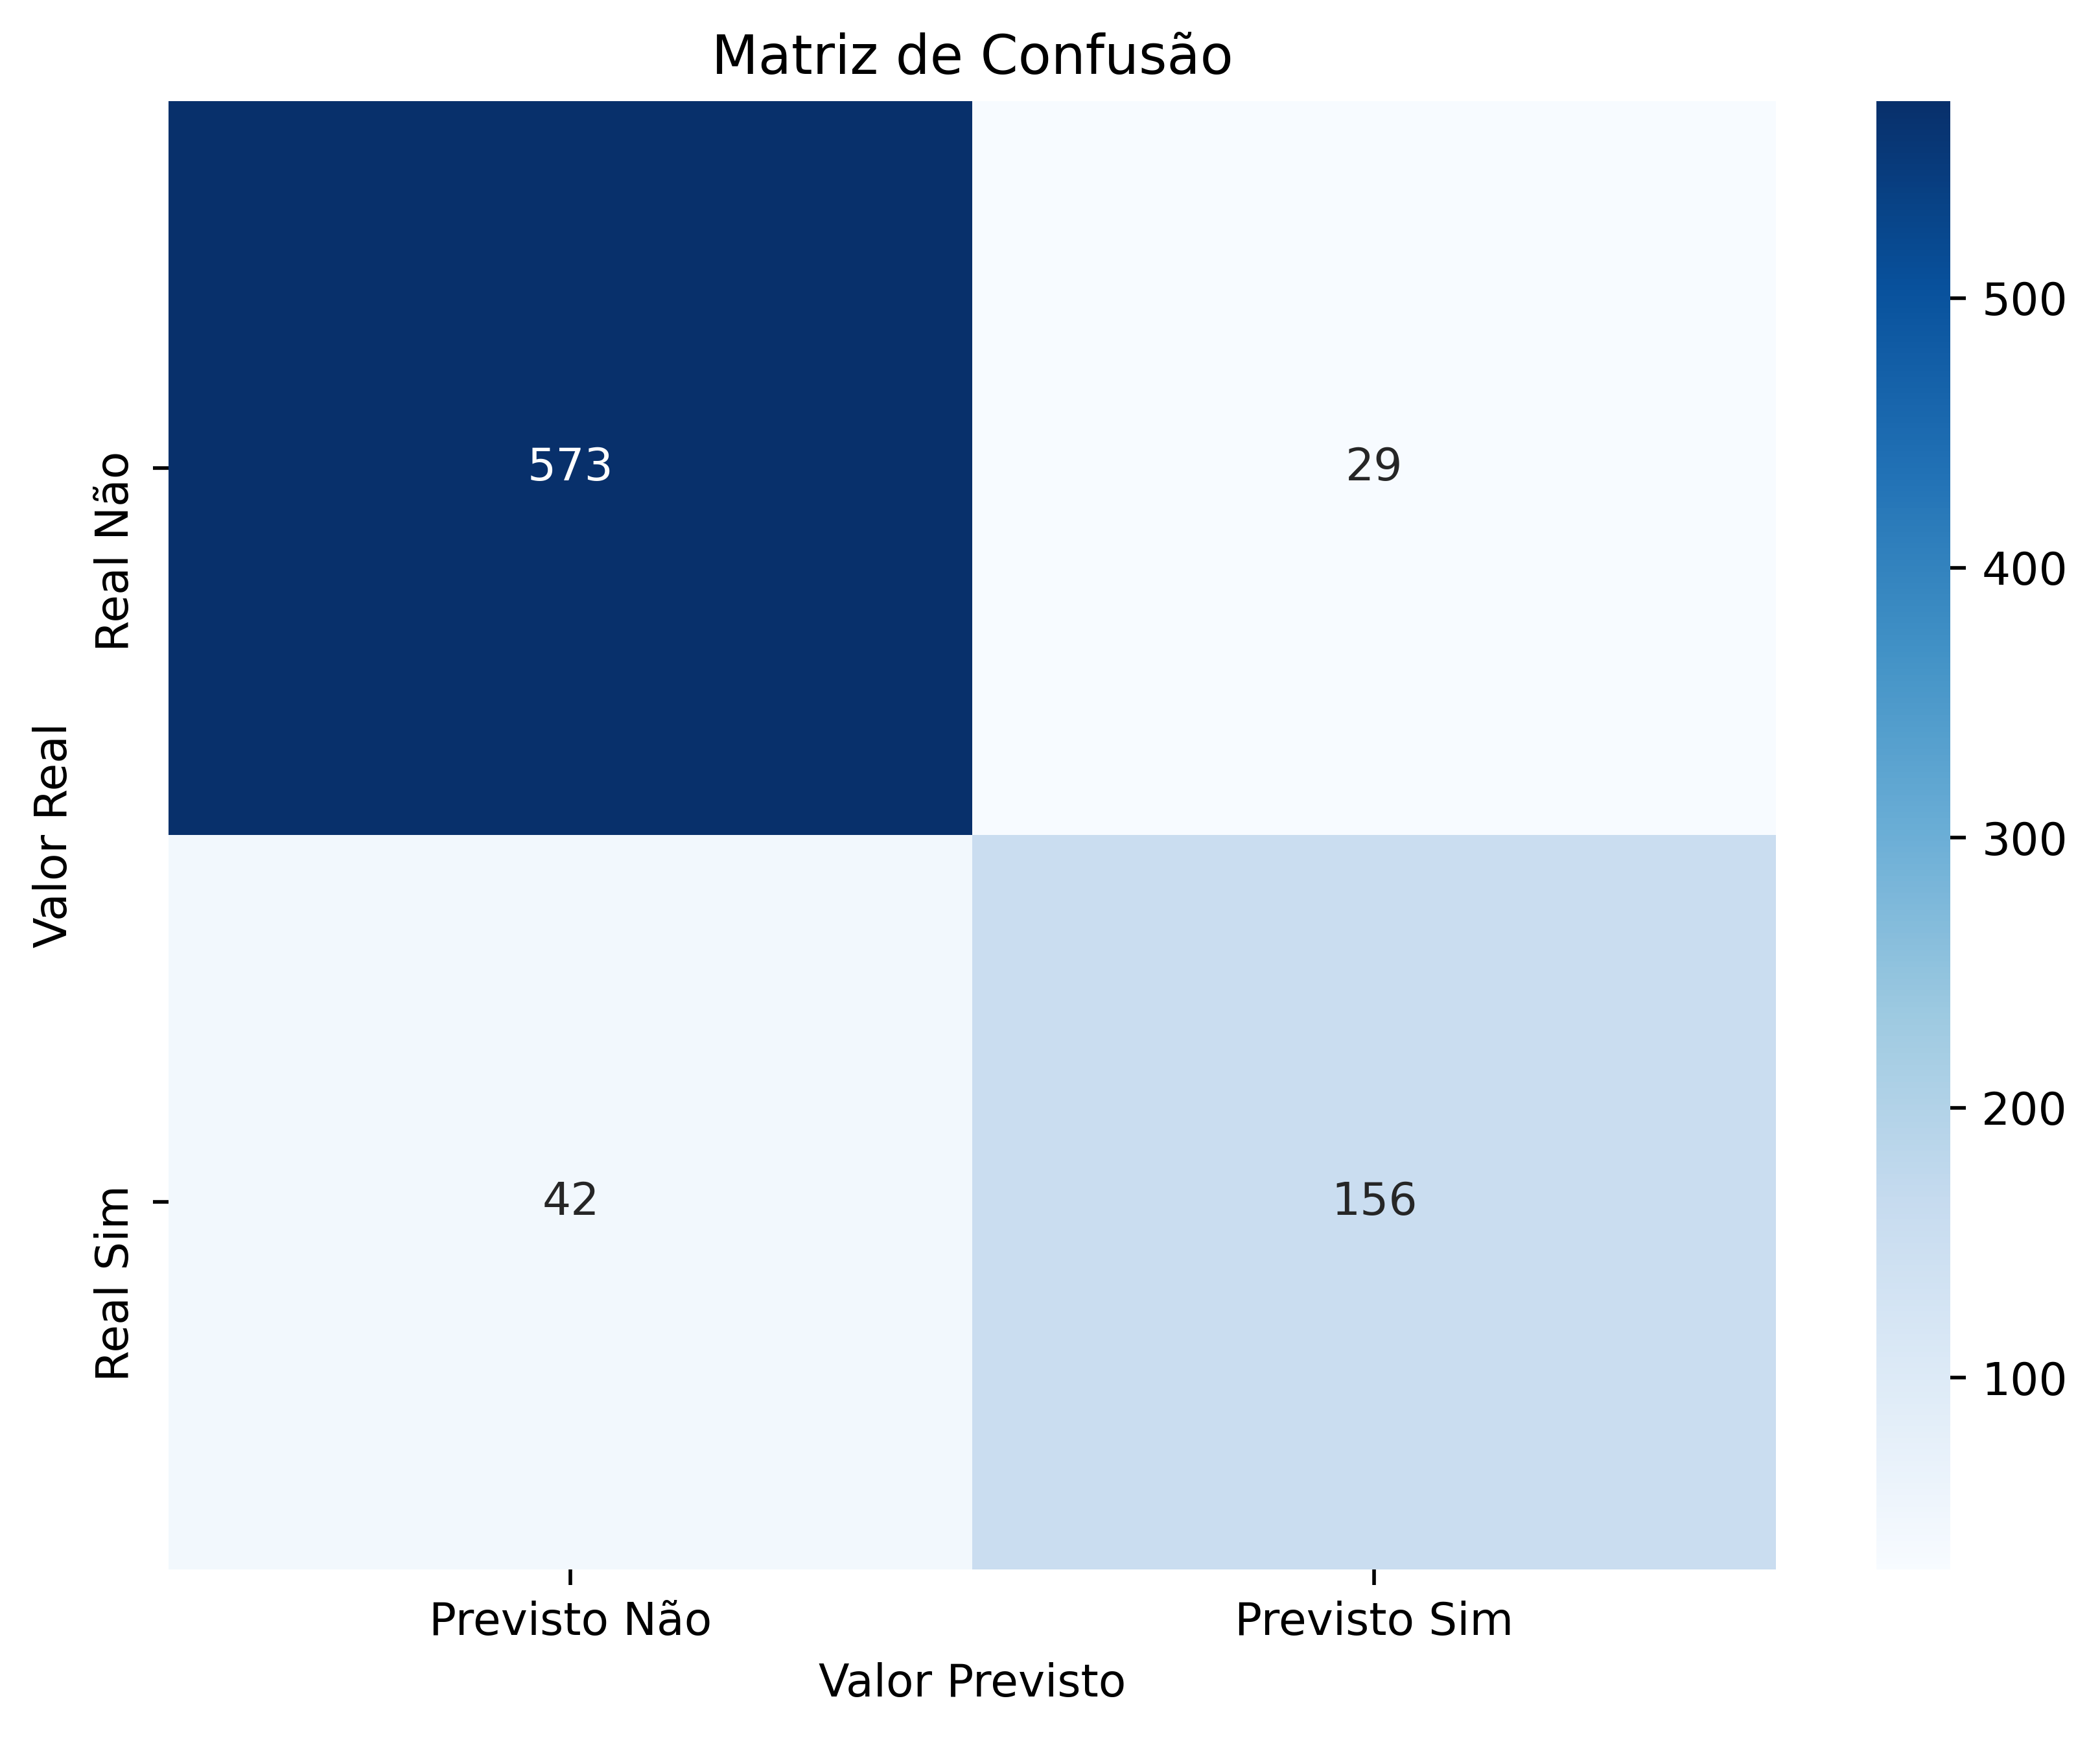

In [21]:
cm_rf = confusion_matrix(y_test, rf_predictions)
NV, PF, NF, PV = cm_rf.ravel() 

plt.figure(figsize=(8, 6), dpi=500)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# 3.2.2 Random Forest aplicando Padronização

In [22]:
rf_model_st = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight = 'balanced')
rf_model_st.fit(X_train_st, y_train)
rf_predictions_st = rf_model_st.predict(X_test_st)
rf_probabilities_st = rf_model_st.predict_proba(X_test_st)[:,1]

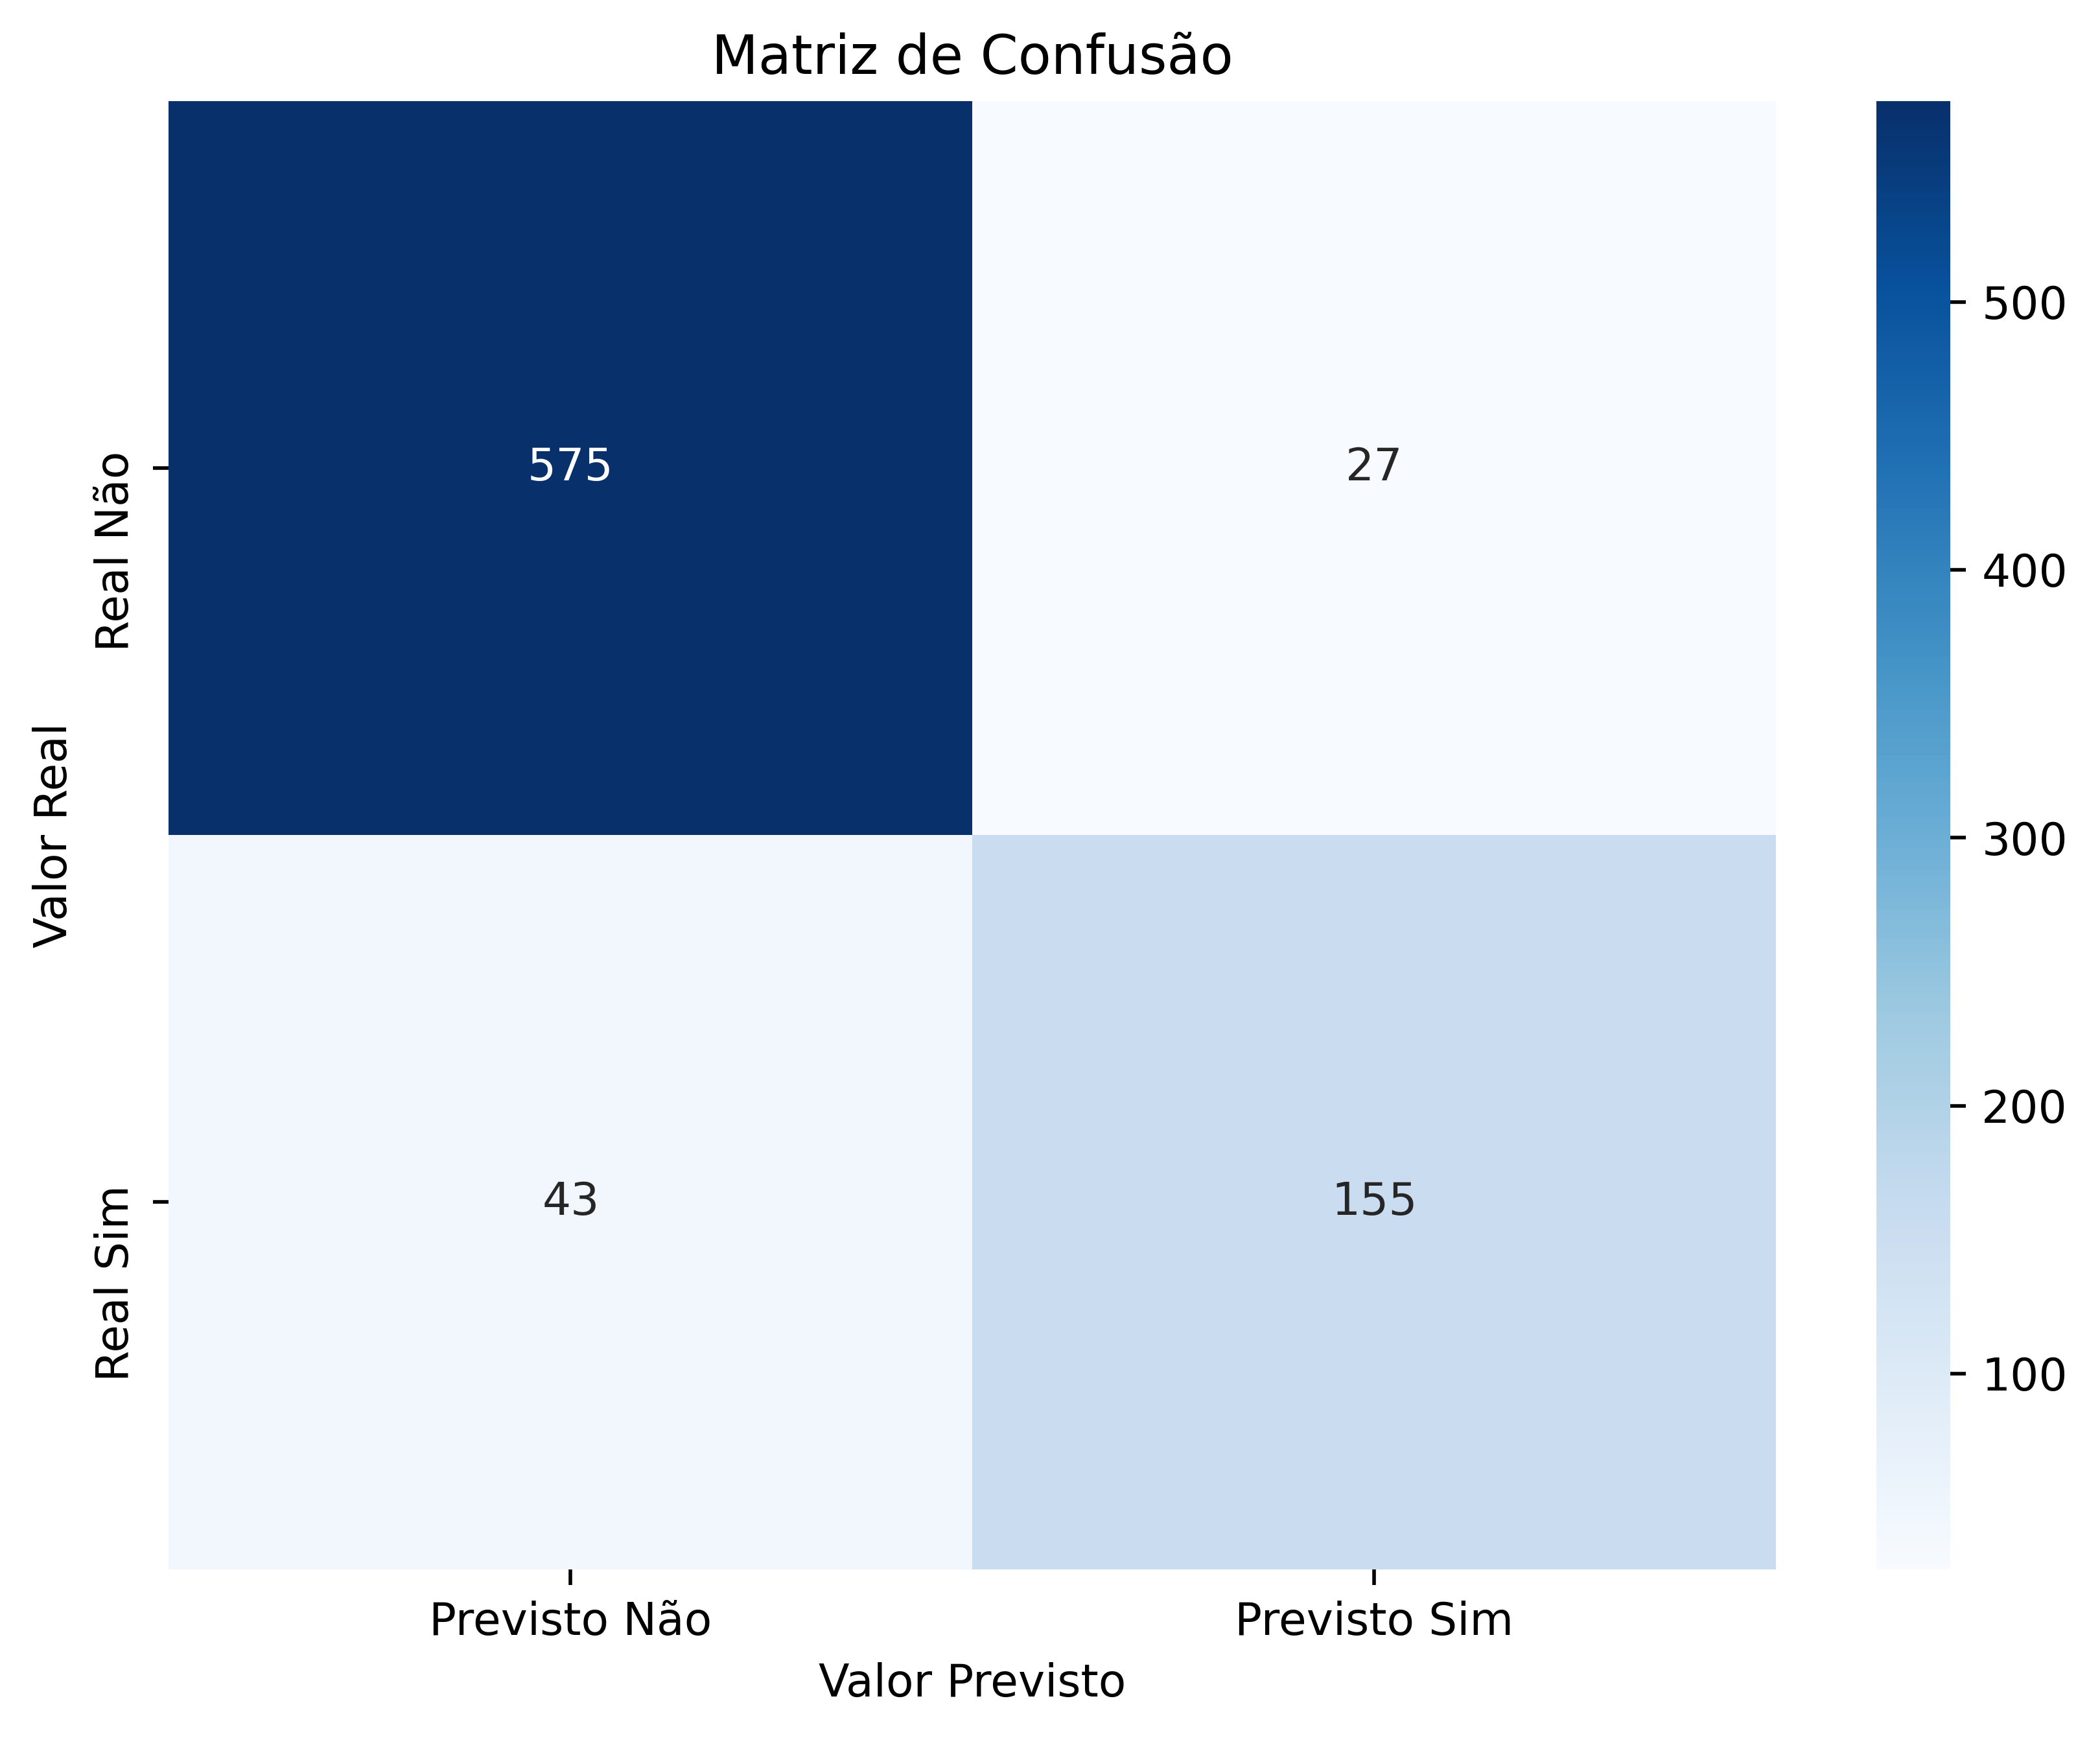

In [23]:
cm_rf_st = confusion_matrix(y_test, rf_predictions_st)
NV, PF, NF, PV = cm_rf_st.ravel() 

plt.figure(figsize=(8, 6), dpi=500)
sns.heatmap(cm_rf_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# 3.2.3 Analizando Matriz de Confusão e Métricas (Random Forest)

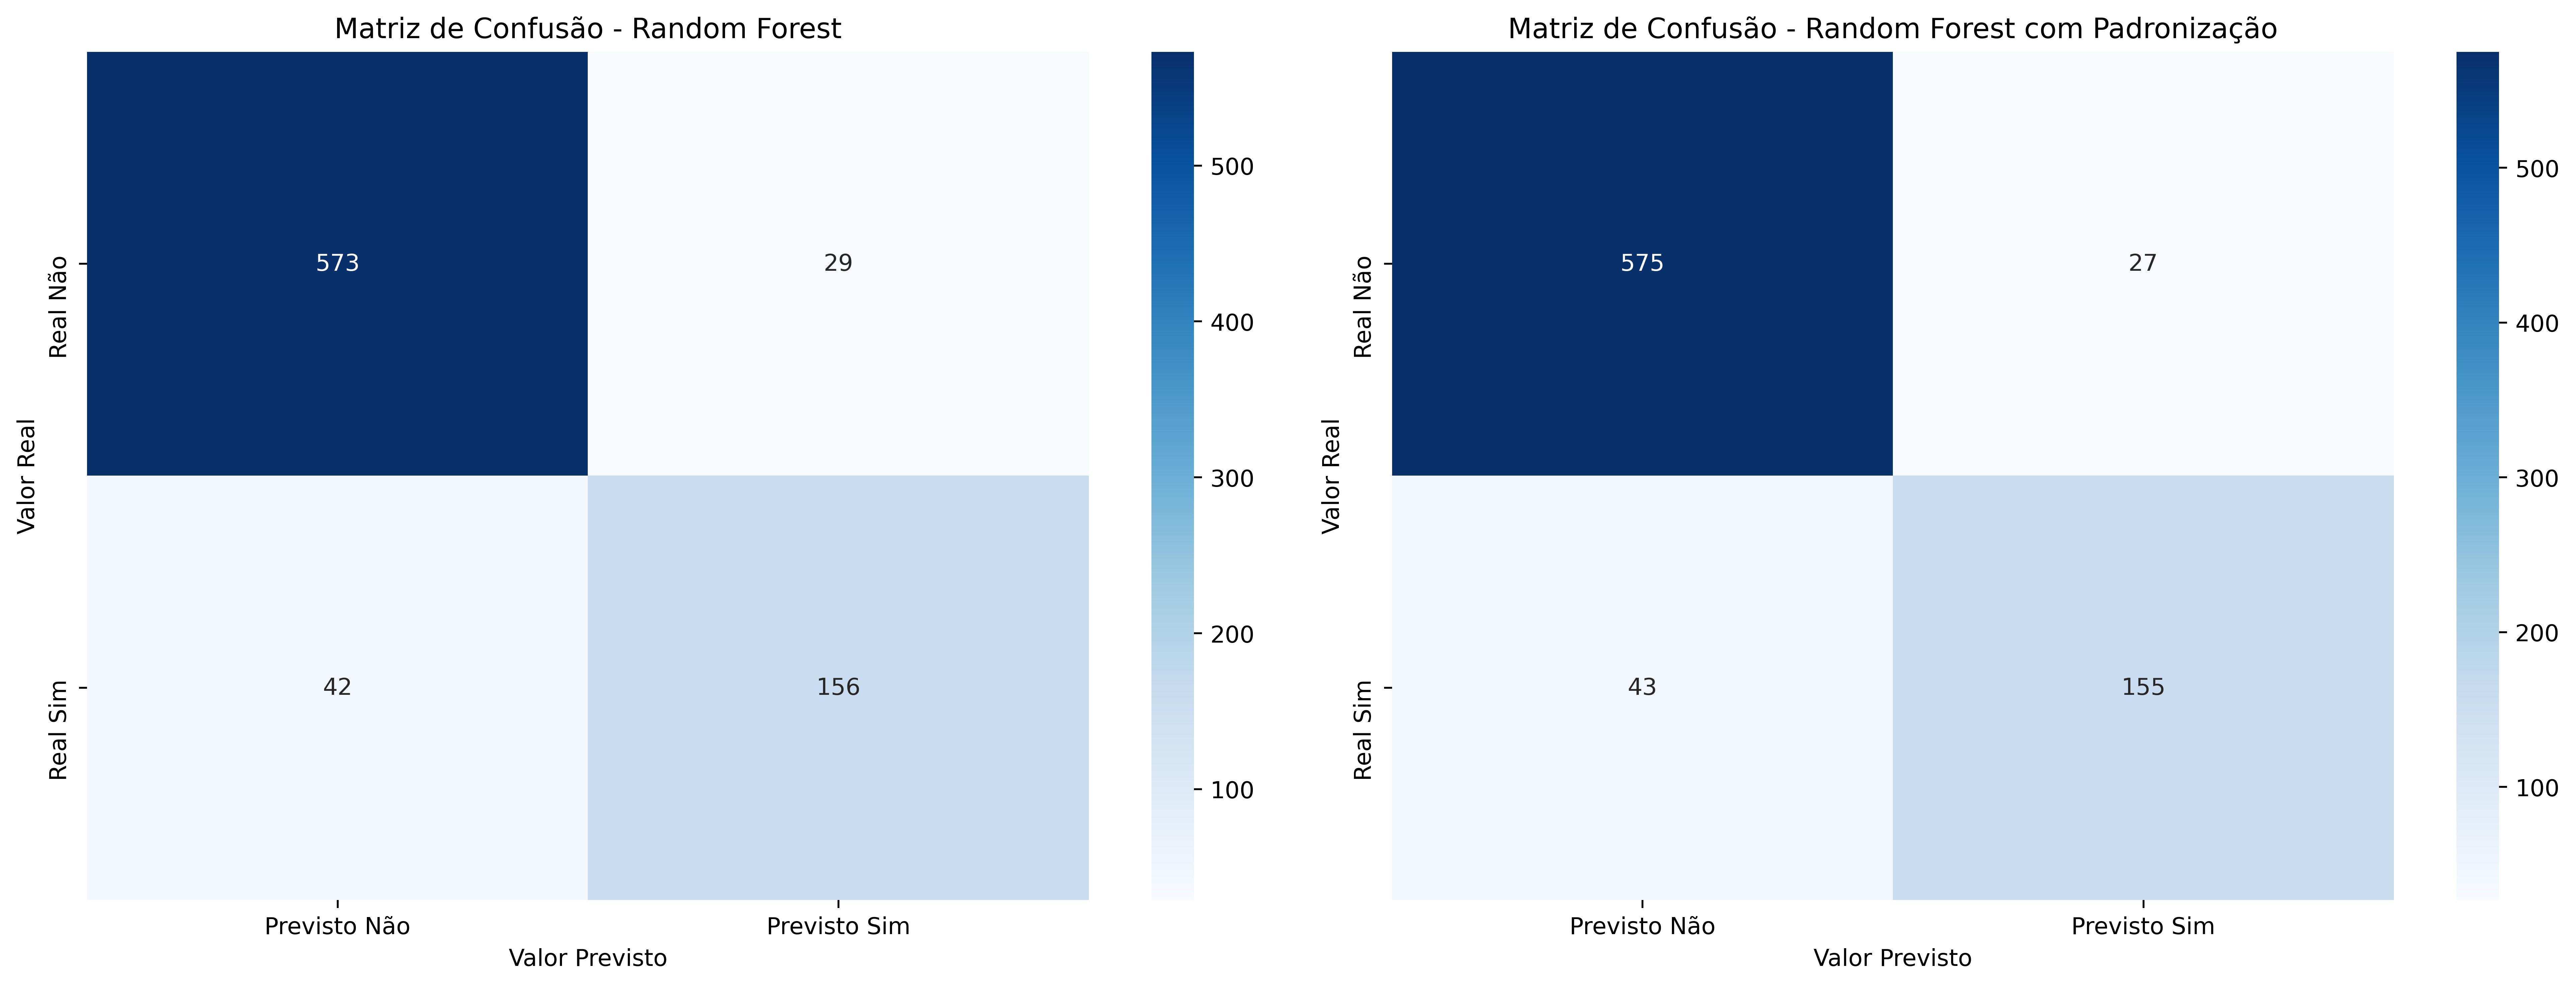

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=500)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[0])
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Previsto')
axes[0].set_title('Matriz de Confusão - Random Forest')

sns.heatmap(cm_rf_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[1])
axes[1].set_ylabel('Valor Real')
axes[1].set_xlabel('Valor Previsto')
axes[1].set_title('Matriz de Confusão - Random Forest com Padronização')

plt.tight_layout()
plt.show()


In [25]:
print('Métricas para a previsão com RandomForest')
print('Acurácia para RandomForest: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precisão para RandomForest: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Sensibilidade para RandomForest: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1 para RandomForest: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC para RandomForest: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))
print('\n')
print('Métricas para a previsão com RandomForest com Padronização')
print('Acurácia para RandomForest com Padronização: {:.2f}'.format(accuracy_score(y_test, rf_predictions_st)))
print('Precisão para RandomForest com Padronização: {:.2f}'.format(precision_score(y_test, rf_predictions_st)))
print('Sensibilidade para RandomForest com Padronização: {:.2f}'.format(recall_score(y_test, rf_predictions_st)))
print('F1 para RandomForest com Padronização: {:.2f}'.format(f1_score(y_test, rf_predictions_st)))
print('ROC_AUC para RandomForest com Padronização: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities_st)))

Métricas para a previsão com RandomForest
Acurácia para RandomForest: 0.91
Precisão para RandomForest: 0.84
Sensibilidade para RandomForest: 0.79
F1 para RandomForest: 0.81
ROC_AUC para RandomForest: 0.97


Métricas para a previsão com RandomForest com Padronização
Acurácia para RandomForest com Padronização: 0.91
Precisão para RandomForest com Padronização: 0.85
Sensibilidade para RandomForest com Padronização: 0.78
F1 para RandomForest com Padronização: 0.82
ROC_AUC para RandomForest com Padronização: 0.97


# 3.3 Comparando todos resultados

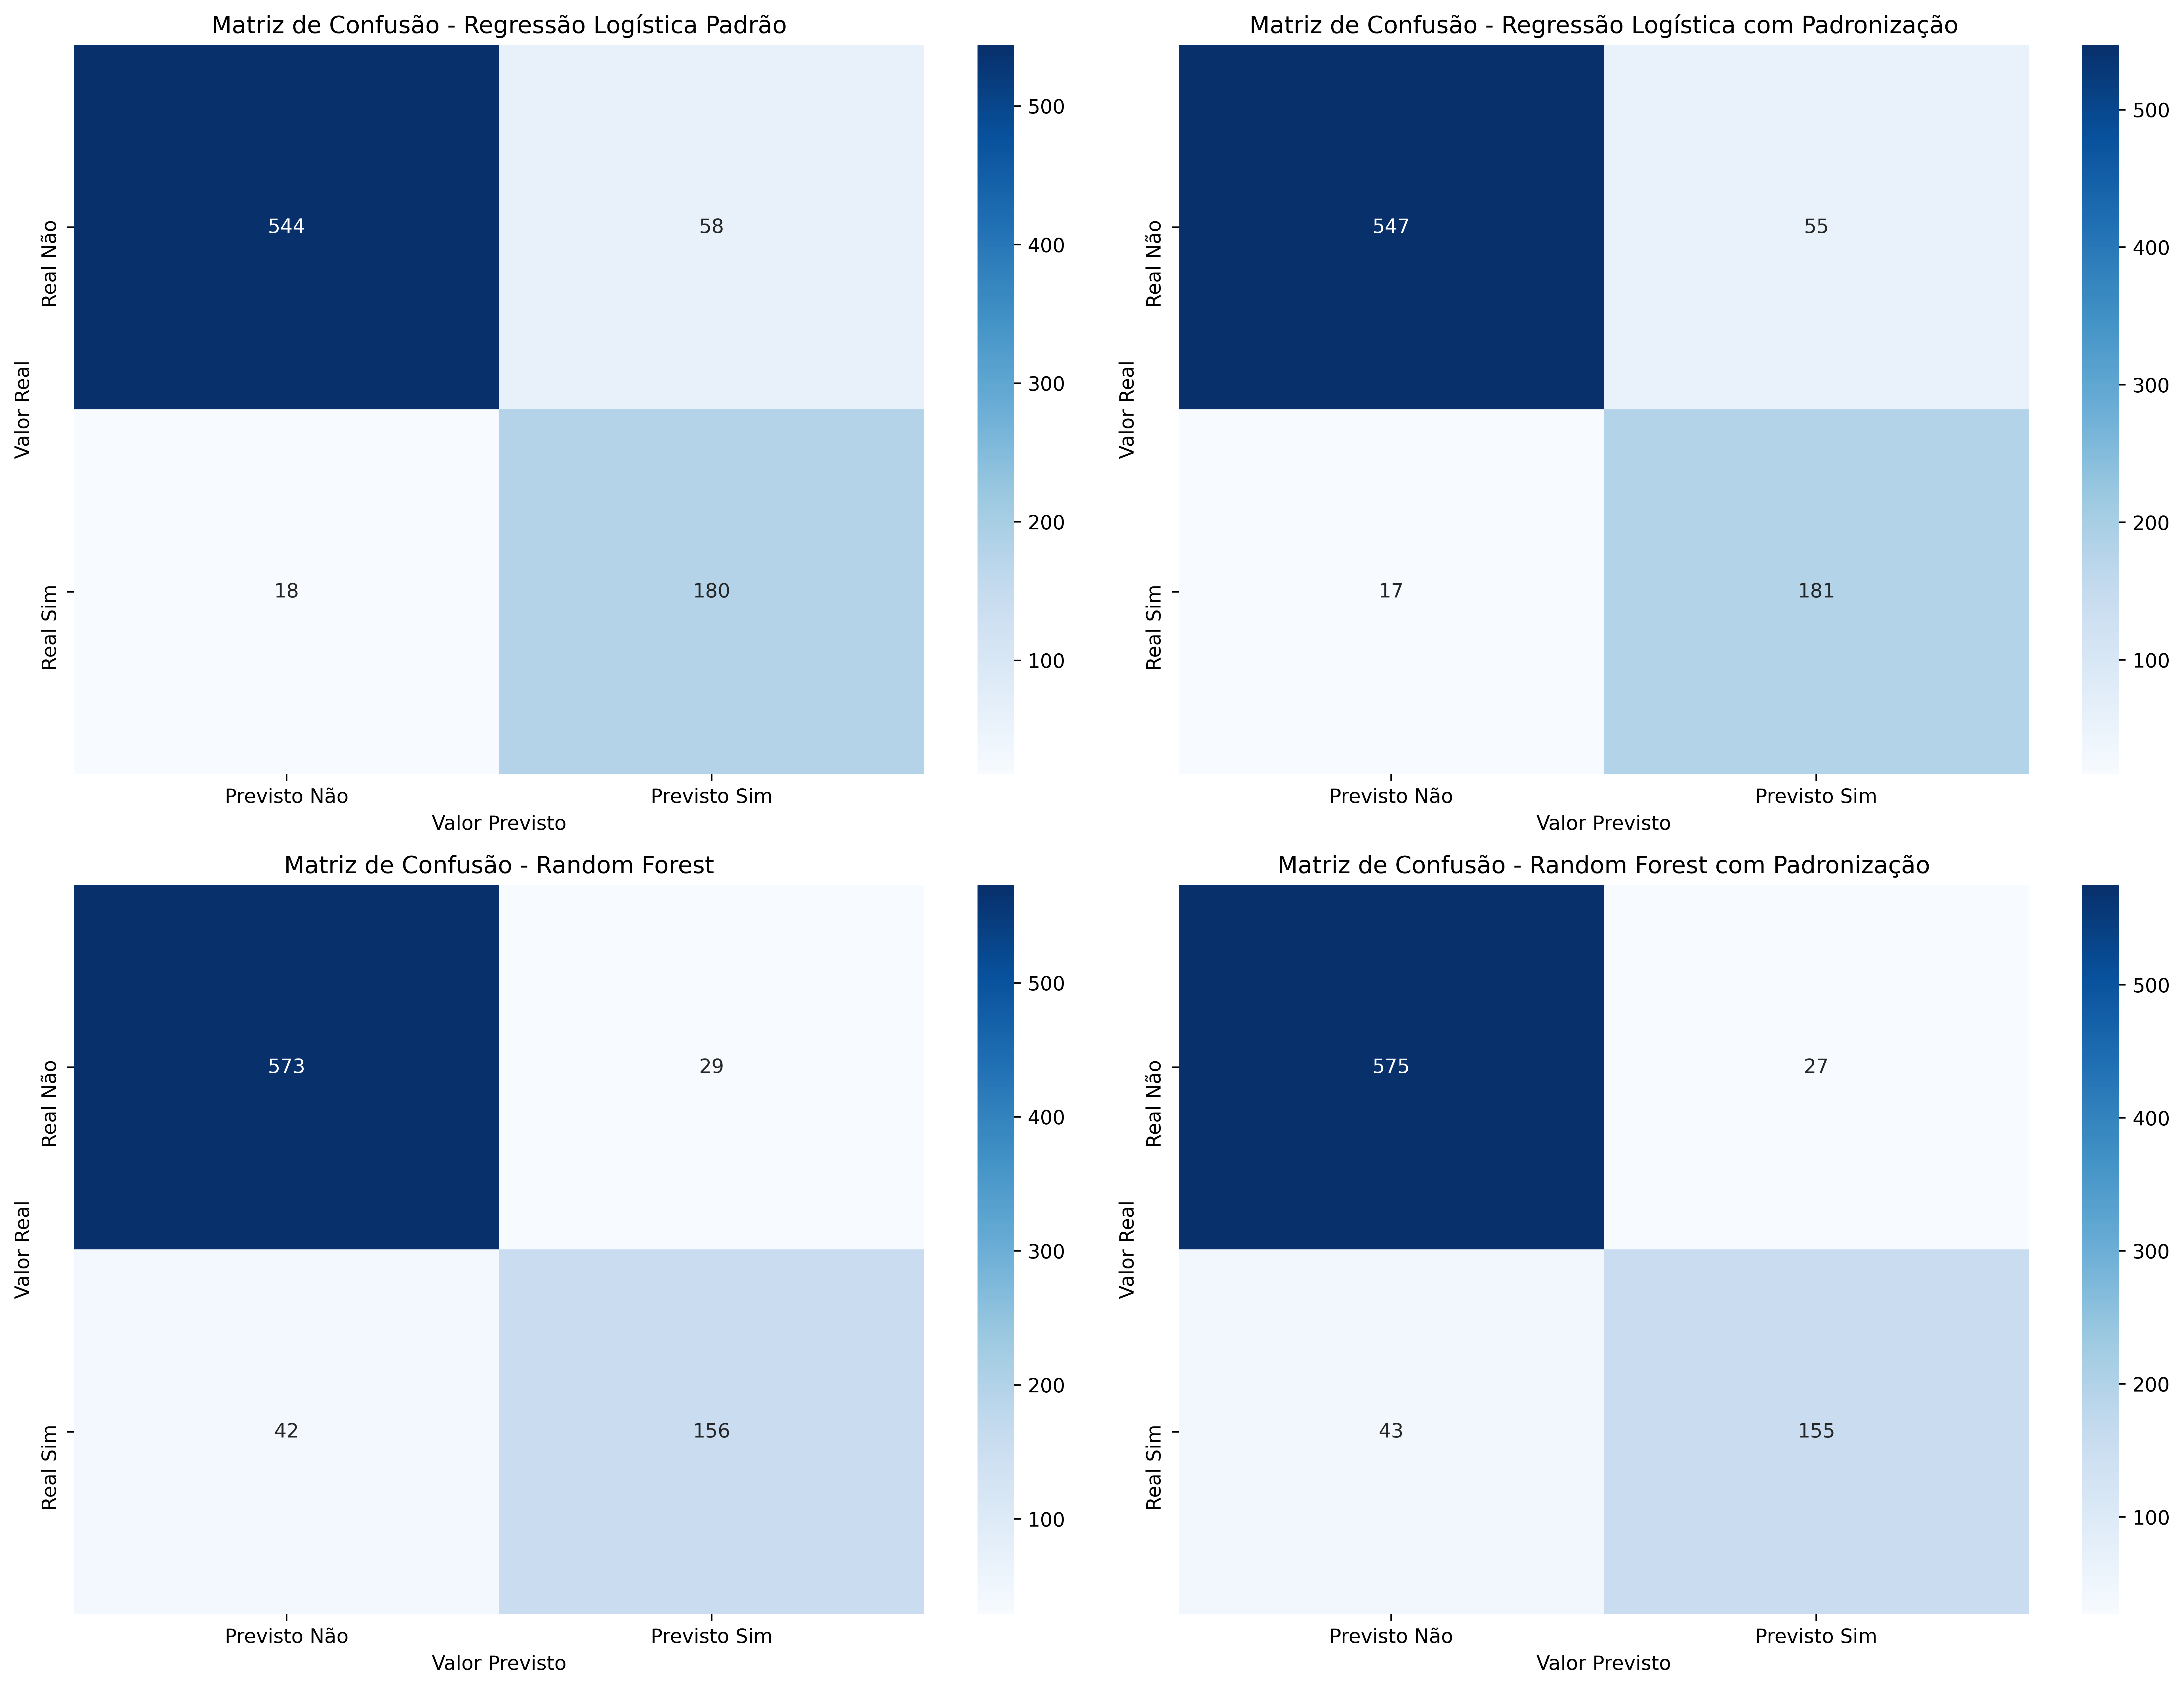

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi=500)

sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[0, 0])
axes[0, 0].set_ylabel('Valor Real')
axes[0, 0].set_xlabel('Valor Previsto')
axes[0, 0].set_title('Matriz de Confusão - Regressão Logística Padrão')

sns.heatmap(cm_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[0, 1])
axes[0, 1].set_ylabel('Valor Real')
axes[0, 1].set_xlabel('Valor Previsto')
axes[0, 1].set_title('Matriz de Confusão - Regressão Logística com Padronização')

sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[1, 0])
axes[1, 0].set_ylabel('Valor Real')
axes[1, 0].set_xlabel('Valor Previsto')
axes[1, 0].set_title('Matriz de Confusão - Random Forest')

sns.heatmap(cm_rf_st, annot=True, fmt="d", cmap='Blues', xticklabels=['Previsto Não', 'Previsto Sim'], yticklabels=['Real Não', 'Real Sim'], ax=axes[1, 1])
axes[1, 1].set_ylabel('Valor Real')
axes[1, 1].set_xlabel('Valor Previsto')
axes[1, 1].set_title('Matriz de Confusão - Random Forest com Padronização')

plt.tight_layout()
plt.show()

Na nossa matriz e confusão, podemos analisar se a maioria dos testes se encaixam em Verdadeiros Positivos e Verdadeiros Negativos. 

Comparando Regressão Logística Padrão com RL Padronizada: A padronizada apresentou um melhor resultado ao aumentar tanto os valores de VP e VN. Desse modo, o número de observações em cada grupo está dentro do desejado, validando como um modelo eficiente.

Comparando RandomForest com RF Padronizada: Diferente da Regressão Logística onde obtivemos melhorias nos dois campos Falsos, no Random Forest observamos uma melhoria nos Verdadeiros Negativos, porém uma piora nos Falsos Negativos e nos Verdadeiros Positivos. No entanto, foi uma mudança muito mínima, de apenas 1 teste de diferença. Podemos considerar que os dois métodos apresentam um bom resultado.

In [27]:
print('Proporção entre as classes:\n',churn_data['churn'].value_counts())
print('\n')
print('Métricas para a previsão com regressão logistica')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))
print('\n')
threshold = 0.4
custom_predictions = [0 if i<threshold else 1 for i in probabilities]
print('Métricas para a previsão com limiar personalizado')
print('Acurácia para personalizado: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precisão para personalizado: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Sensibilidade para personalizado: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 para personalizado: {:.2f}'.format(f1_score(y_test, custom_predictions)))
print('\n')
print('Métricas para a previsão de regressão logística utilizando padronização')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions_st)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions_st)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions_st)))
print('F1: {:.2f}\n'.format(f1_score(y_test, predictions_st)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_st)))
print('\n')
print('Métricas para a previsão com RandomForest')
print('Acurácia para RandomForest: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precisão para RandomForest: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Sensibilidade para RandomForest: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1 para RandomForest: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC para RandomForest: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))
print('\n')
print('Métricas para a previsão com RandomForest com Padronização')
print('Acurácia para RandomForest com Padronização: {:.2f}'.format(accuracy_score(y_test, rf_predictions_st)))
print('Precisão para RandomForest com Padronização: {:.2f}'.format(precision_score(y_test, rf_predictions_st)))
print('Sensibilidade para RandomForest com Padronização: {:.2f}'.format(recall_score(y_test, rf_predictions_st)))
print('F1 para RandomForest com Padronização: {:.2f}'.format(f1_score(y_test, rf_predictions_st)))
print('ROC_AUC para RandomForest com Padronização: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities_st)))


Proporção entre as classes:
 0    2939
1    1061
Name: churn, dtype: int64


Métricas para a previsão com regressão logistica
Acurácia: 0.91
Precisão: 0.76
Sensibilidade: 0.91
F1: 0.83
ROC_AUC: 0.97


Métricas para a previsão com limiar personalizado
Acurácia para personalizado: 0.89
Precisão para personalizado: 0.72
Sensibilidade para personalizado: 0.94
F1 para personalizado: 0.81


Métricas para a previsão de regressão logística utilizando padronização
Acurácia: 0.91
Precisão: 0.77
Sensibilidade: 0.91
F1: 0.83

ROC_AUC: 0.97


Métricas para a previsão com RandomForest
Acurácia para RandomForest: 0.91
Precisão para RandomForest: 0.84
Sensibilidade para RandomForest: 0.79
F1 para RandomForest: 0.81
ROC_AUC para RandomForest: 0.97


Métricas para a previsão com RandomForest com Padronização
Acurácia para RandomForest com Padronização: 0.91
Precisão para RandomForest com Padronização: 0.85
Sensibilidade para RandomForest com Padronização: 0.78
F1 para RandomForest com Padronização: 0.82

Acurácia: quanto mais próximo de 100%, melhor a acurácia. A acurácia exige que as amostras estejam igualmente divididas, então devemos levar em consideração que poderemos encontrar uma acurácia mais próxima da realidade em modelos padronizados.

Precisão: nos mostra qual parte dos objetos são reais. Não é tão dependente das amostras divididas.

Sensibilidade: representa a quantidade de objetos de classe reais no experimento. Um equilibrio entre precisão e sensibilidade é o ideal.

F1 Score: mostra essa razão entre a precisão e a senibilidade. 

Então estamos buscando um modelo que apresente padronização com uma alta acurácia, precisão e sensibilidade boas e equilibradas, evidenciada pelo valor de F1.

Todos os nossos modelos testados tiveram bons resultados, mas os que apresentaram os melhores resultados foram Regressão Logística Padronizada e Random Forest Padronizado. Ambos possuem uma boa acurácia e um bom equilíbrio nos valores. Se nosso modelo exigir mais alertas, é recomendado o modelo de RandomForest devido à alta precisão.

Com a utilização do Random Forest, nossa previsão é que 155 clientes irão cancelar seus contratos com a academia nesse mês.

# 3.4 Agrupamentos 

Vou agora realizar agrupamentos dos clientes pra melhorar a previsão.

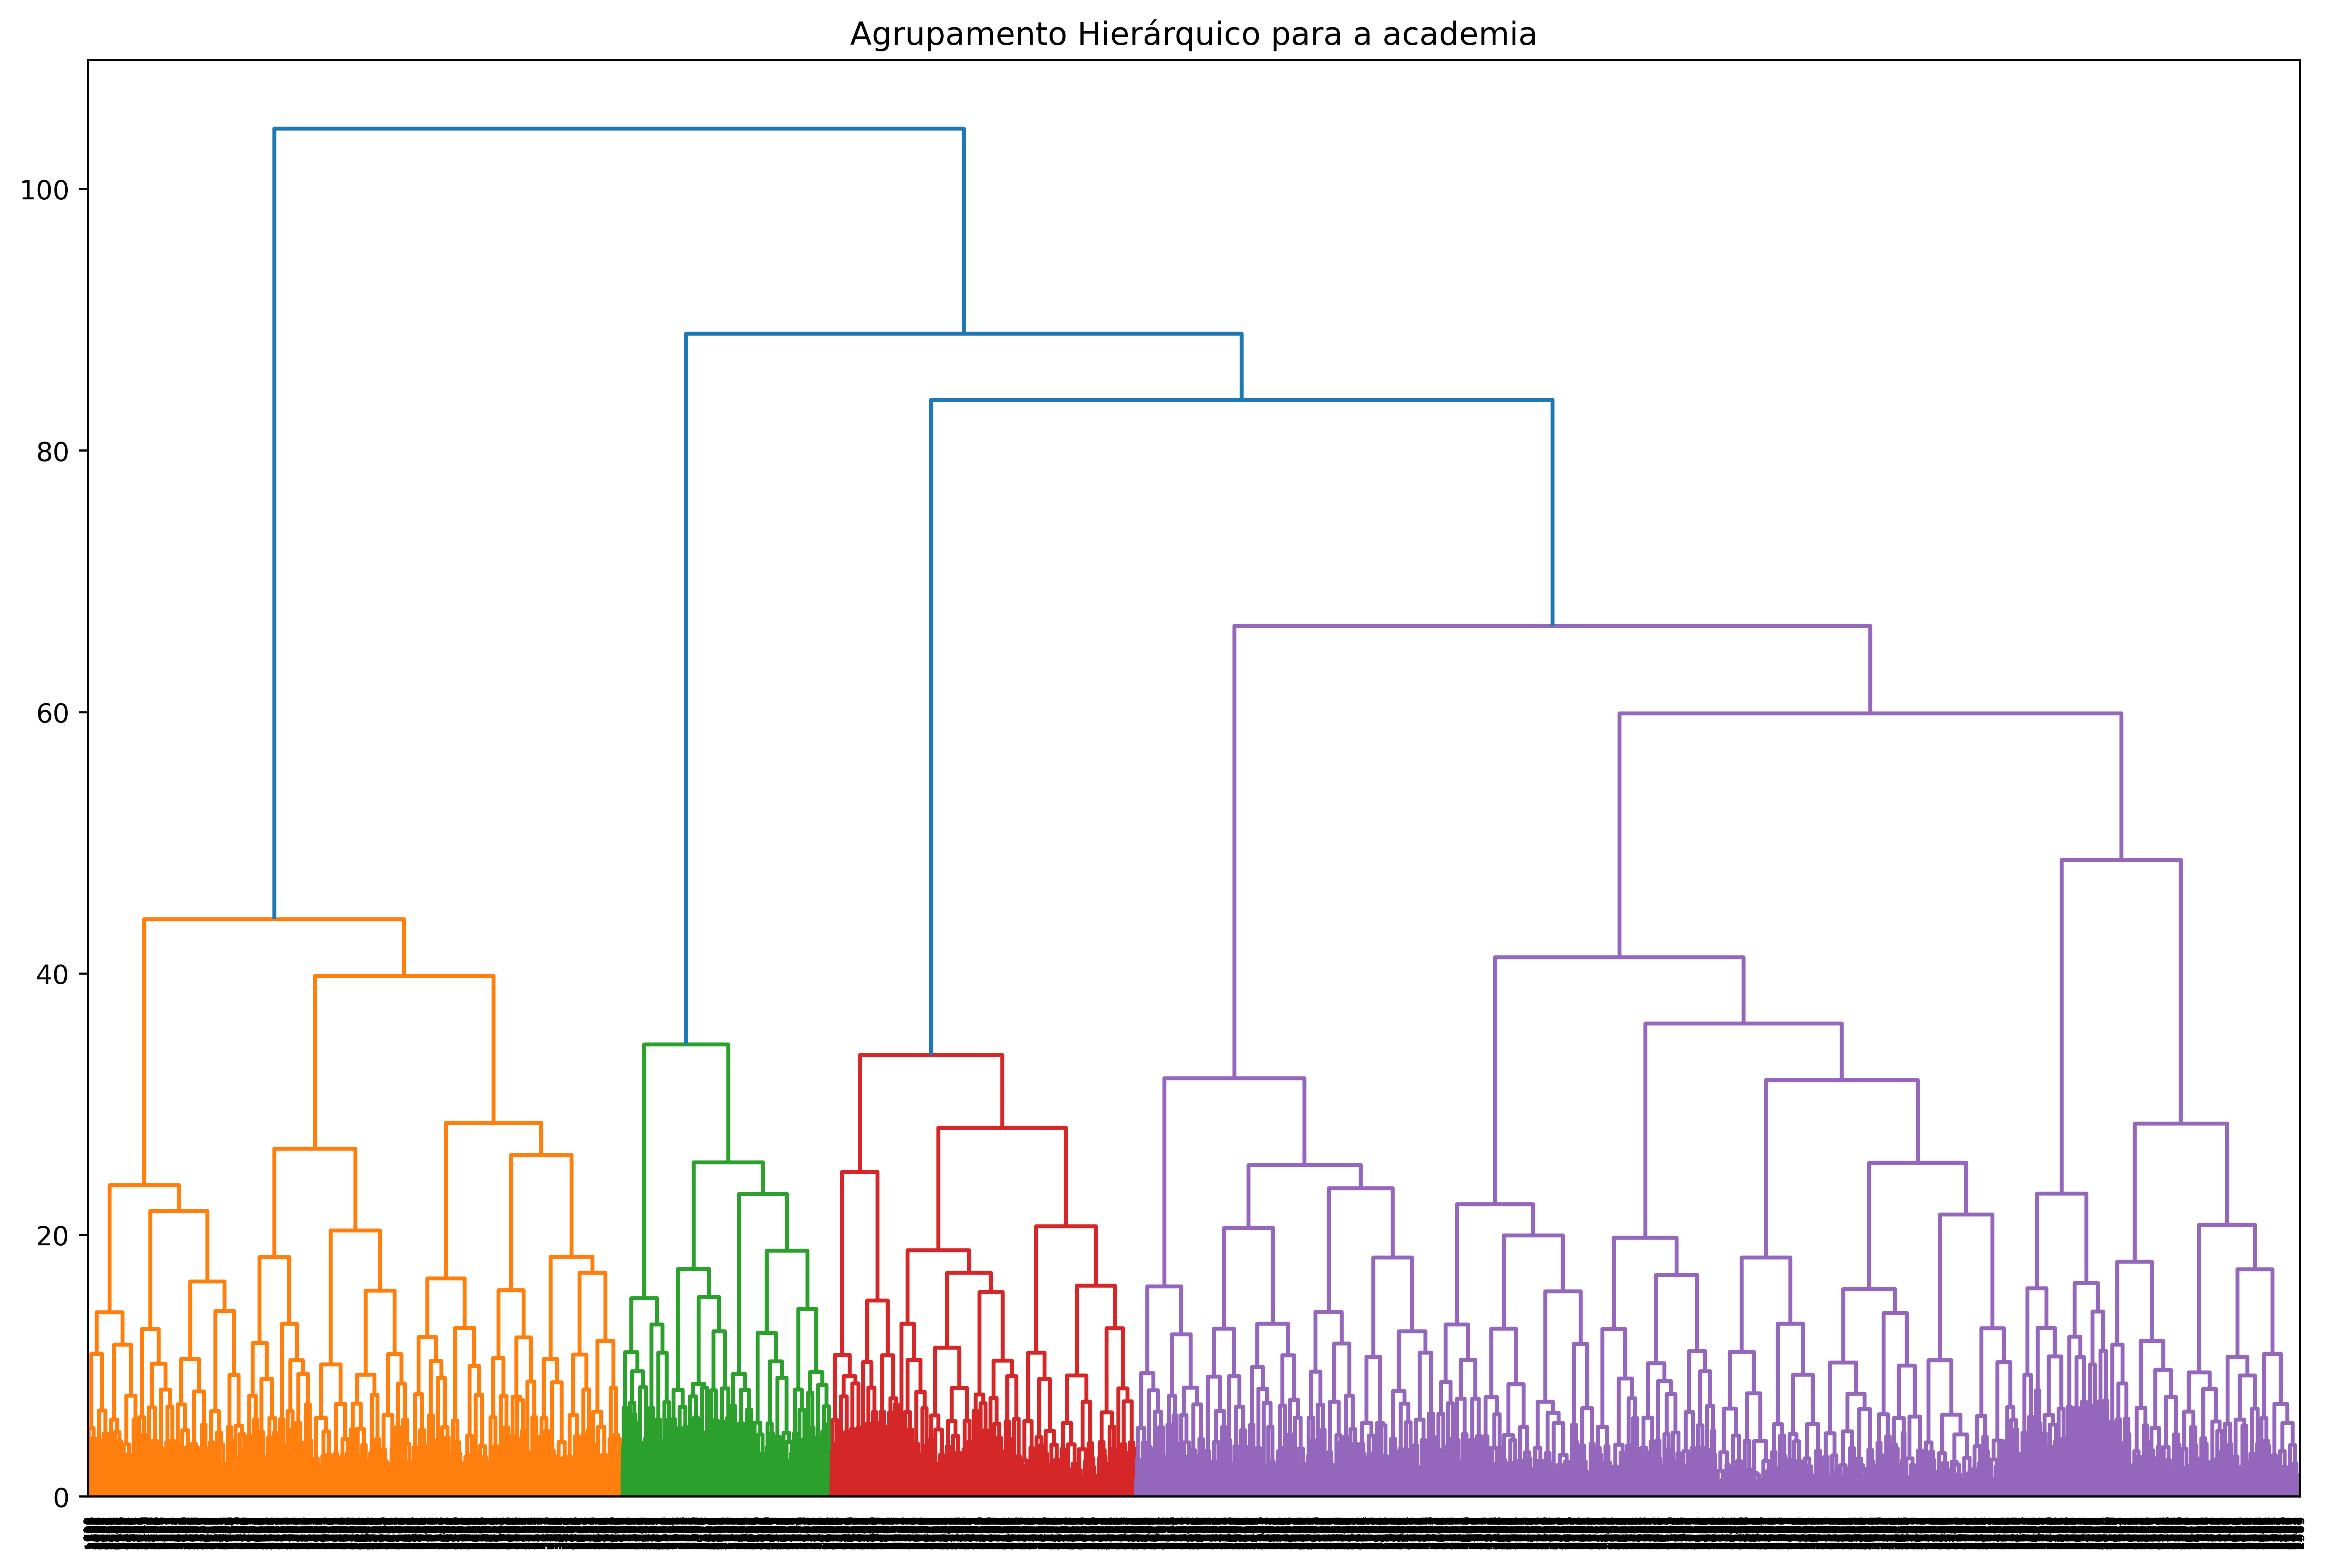

In [28]:


linked = linkage(X_scaler, method = 'ward') 

plt.figure(figsize=(15, 10), dpi = 500)  
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico para a academia')
plt.show() 

# 3.4.1 Analisando médias de clusters

In [29]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_scaler)

churn_data['cluster_km'] = labels
churn_data.groupby(['cluster_km']).mean()


gender  near_location   partner  promo_friends  phone  \
cluster_km                                                            
0           0.523316       0.862694  0.471503       0.305699    0.0   
1           0.564858       0.977594  0.343160       0.221698    1.0   
2           0.498531       0.960823  0.783546       0.575906    1.0   
3           0.483845       1.000000  0.355412       0.242326    1.0   
4           0.497041       0.000000  0.461538       0.078895    1.0   

            contract_period  group_visits        age  \
cluster_km                                             
0                  4.777202      0.427461  29.297927   
1                  2.550708      0.472877  30.122642   
2                 10.854065      0.539667  29.972576   
3                  1.962843      0.340065  28.144588   
4                  2.378698      0.218935  28.479290   

            avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster_km                                                                  
0                             144.208179               4.466321  3.940415   
1                             161.268043               2.349057  4.916274   
2                             161.128963               9.920666  4.723800   
3                             130.918569               1.872375  2.390953   
4                             135.631940               2.224852  2.812623   

            avg_class_frequency_total  avg_class_frequency_current_month  \
cluster_km                                                                 
0                            1.854211                           1.723967   
1                            2.812928                           2.807517   
2                            2.003225                           1.996705   
3                            1.233389                           0.995856   
4                            1.662253                           1.480228   

               churn  
cluster_km            
0           0.266839  
1           0.074292  
2           0.027424  
3           0.519386  
4           0.441815

In [30]:
churn_data.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.266839
1    0.074292
2    0.027424
3    0.519386
4    0.441815
Name: churn, dtype: float64

Analisando os valores médios dos clusters podemos tirar conclusões específicas sobre cada um deles:
    
    - Cluster 0: Possui uma alta taxa de rotatitividade (45%). Apresenta valores médios baixos para todas características, como baixo lifetime (2.7 meses), baixa frequência nas aulas (1.66), e uma média de contratos baixos. Além disso, um ponto muito importante nesse cluster é que a maioria dos clientes NÃO está próximo da academia. Isso é o maior fator diferencial desse agrupamento.
    
    - Cluster 1: Aqui já temos a maioria dos clientes próxima, e observamos uma diminuição no cancelamento (24.8%). Quando comparado aos outros clusters, podemos atribuir que as médias das características estão na média entre os clusters, possuindo uma frequência boa mas não tão alta nas classes (1.73), um aumento no número de meses de contrato em relação ao cluster 0 (3,1 meses). Além disso, grande parte dos clientes trabalham em empresas parceiras da academia. Isso pode ser um fator relevante que implica que esse grupo participa das atividades da academia por ser um benefício da empresa, e não por necessariamente se sentirem com vontade de participar.
    
    - Cluster 2: Muito próximo do cluster 1, com a diferença que existe um número muito menor de clientes que trabalham em empresas parceiras. Nesse caso, a taxa de rotatividade é baixa (6.8%), enquanto a frequência de participação aumenta em relação aos clusters anteriores (2.89), assim como o período de contrato (2.8 meses). Aqui a média de idade também é a maior dentre os clusters, e são clientes que moram próximos à academia. 
    
    - Cluster 3: Grupo que possui a menor rotatividade (2.2%), e também possui os maiores tempos de contratos. Contratos longos de quase 12 meses em média, evidencia que clientes que possuem esses contratos anuais são extremamente menos propensos à cancelar sua assinatura na academia. Apesar de possuírem uma frequência menor em relação ao cluster 2, são os clientes que possuem o maior gasto adicional, com uma média de 164.93 de gastos adicionais. Esses clientes são clientes leais e a meta da academia. Quanto mais clientes a academia inserir nesse agrupamento, maior o lucro à longo prazo. Isso já indica que promoções de contratos anuais são uma opção excelente para a empresa. 
    
    - Cluster 4: Maior taxa de rotatividade (52.6%). Possuem um tempo baixo de meses de contrato (2 meses), e uma frequência baixa, menor ainda que o cluster 0 (1.28). Muito provavelmente são clientes que estão testando à academia e não se adaptaram. Seria interessante investigar os motivos que levaram à essa não adaptação, através de formulários de pesquisa e satisfação, tentando encontrar qual o motivo desses clientes não se manterem na academia. Se diferem fortemente do cluster 0 pois aqui os clientes moram próximos à academia. É fácil identificar o problema da distância no cluster 0 pois as pessoas vão buscar lugares mais próximos de onde eles moram. Porém aqui não existe esse problema, então provavelmente os clientes tiveram alguma experiência negativa no seu período de contrato.

In [31]:
churn_data['cluster_km'].value_counts()

3    1238
2    1021
1     848
4     507
0     386
Name: cluster_km, dtype: int64

# 3.4.2 Analisando gráficos de clusterização

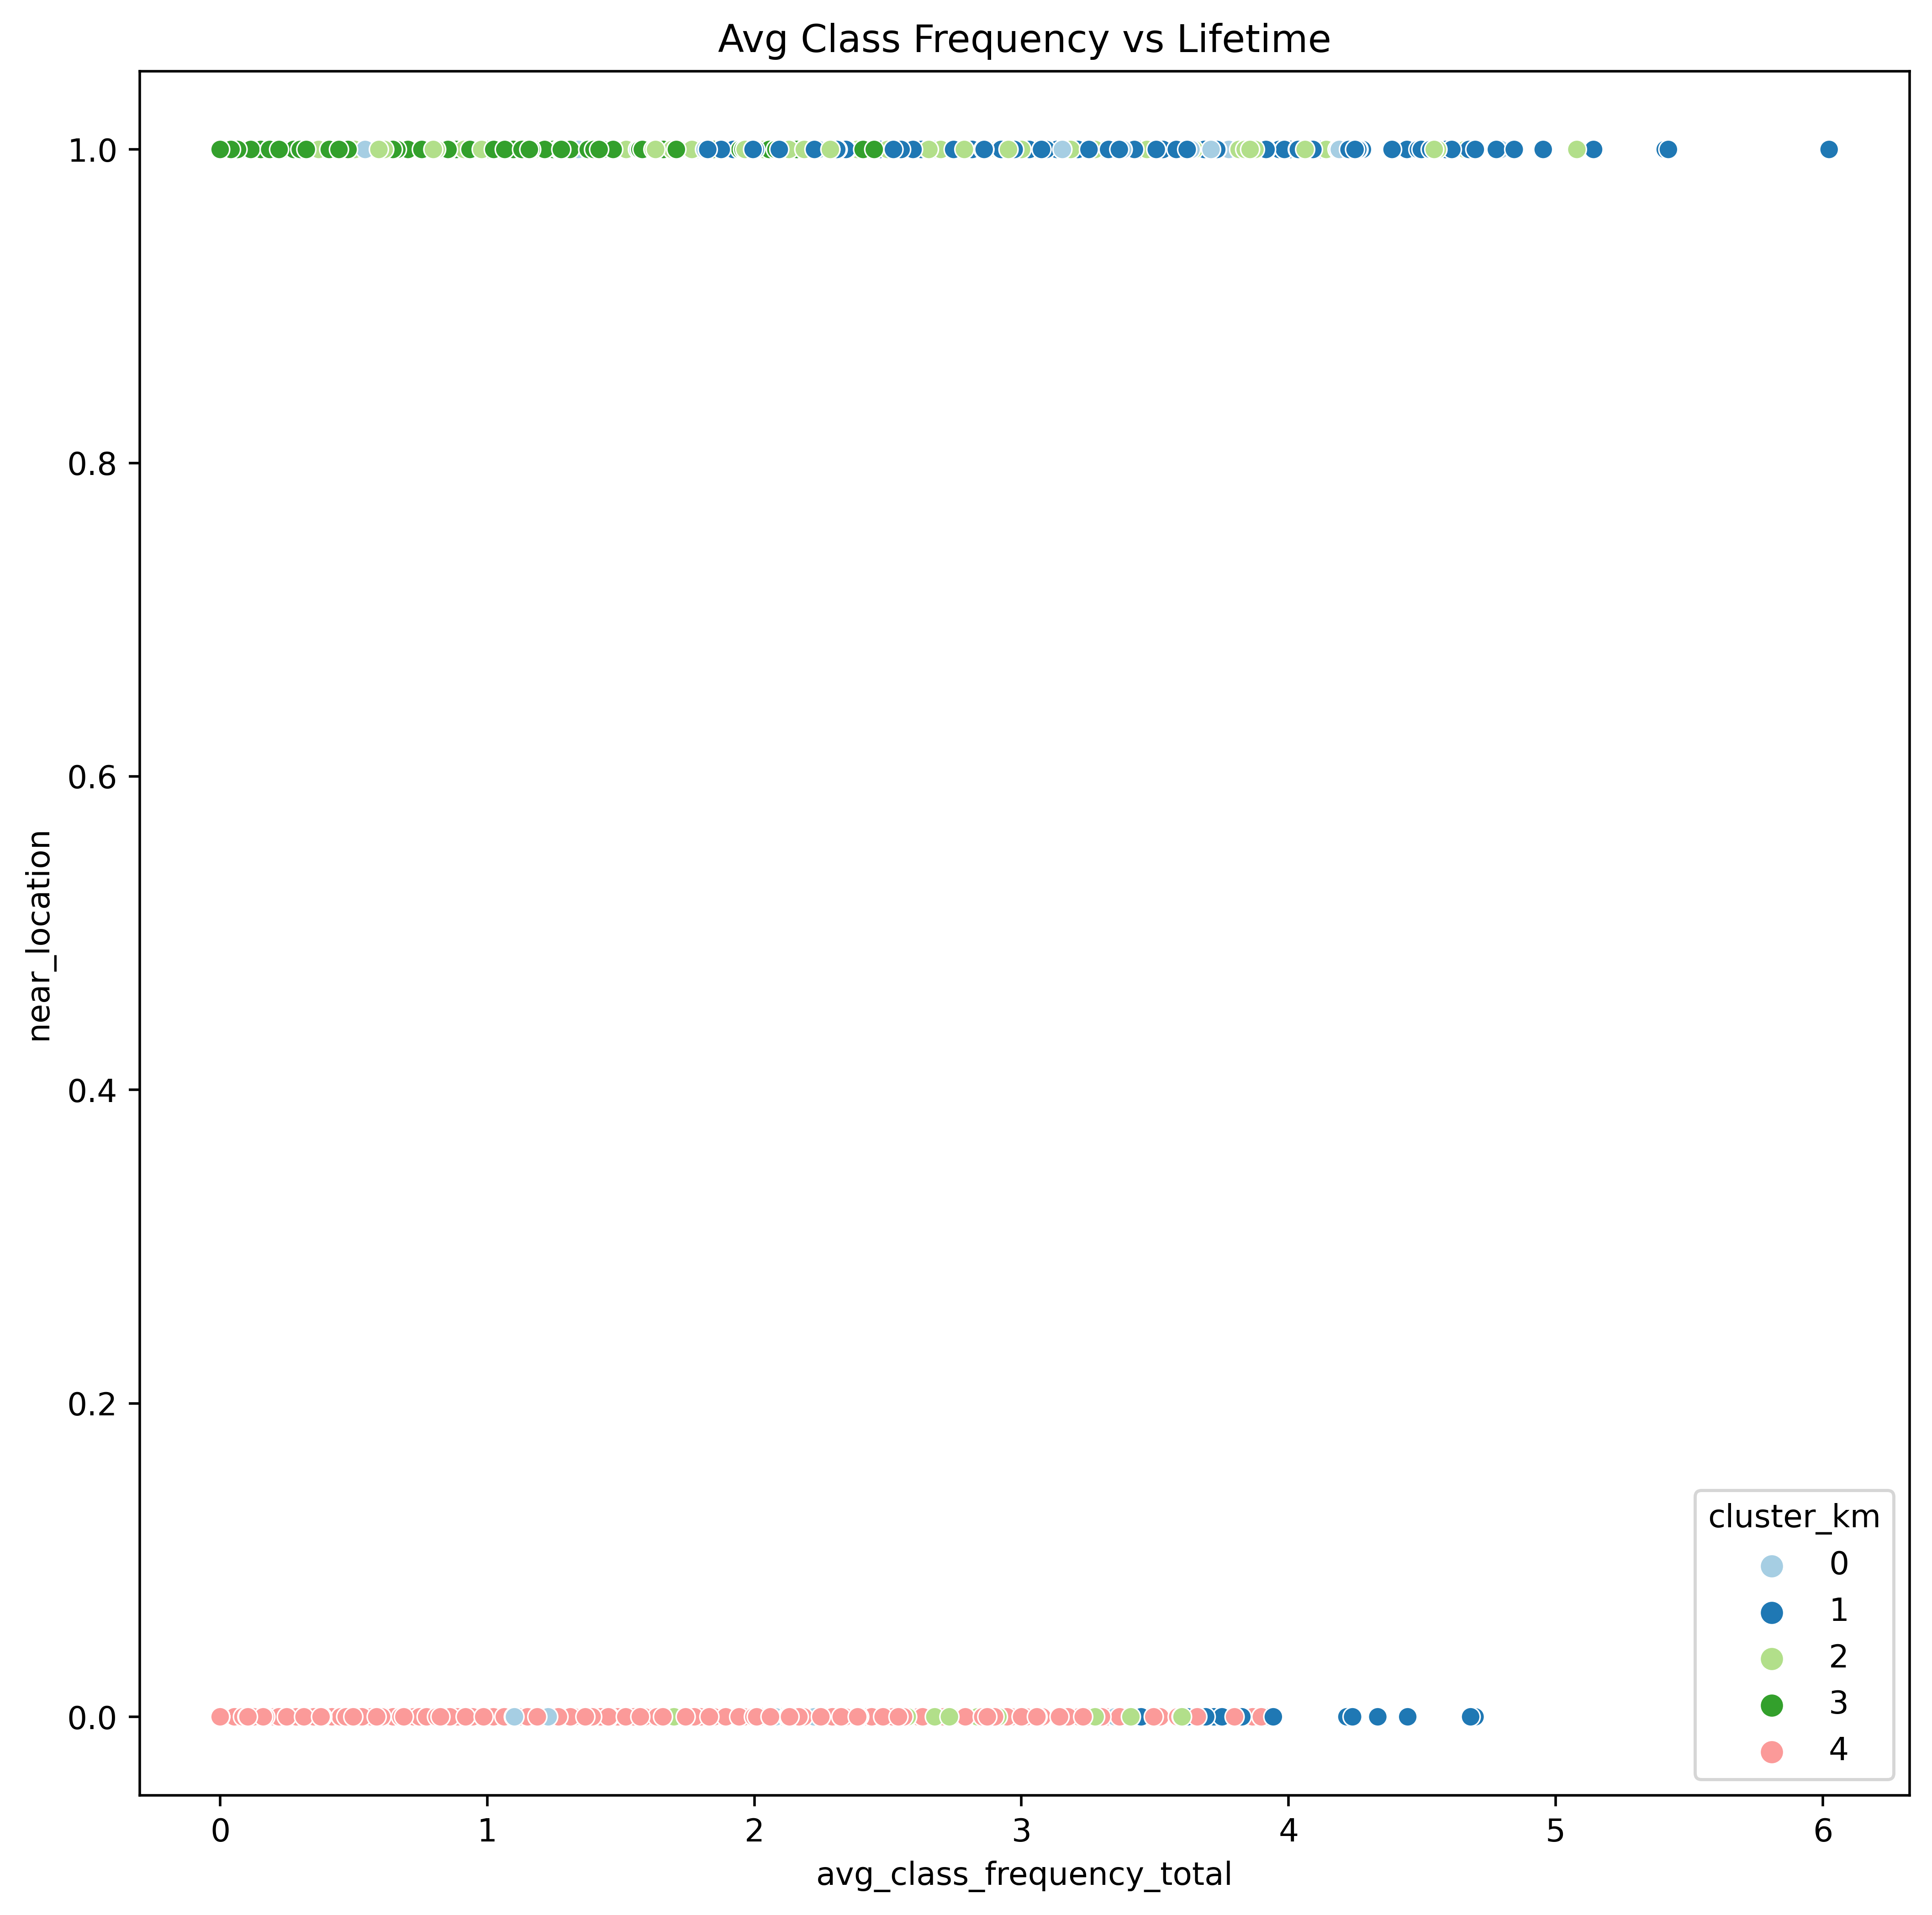

In [32]:
plt.figure(figsize=(10, 10), dpi = 500)
sns.scatterplot(x = churn_data['avg_class_frequency_total'], y = churn_data['near_location'], hue=churn_data['cluster_km'], palette='Paired')
plt.title('Avg Class Frequency vs Lifetime')
plt.show()

Quando comparamos a frequência de participação com a distância podemos ver claramente a diferenciação dos clusters. Enquanto alguns clientes participam mesmo longe, grande parte dos agrupamentos tendem a morar mais próximos.

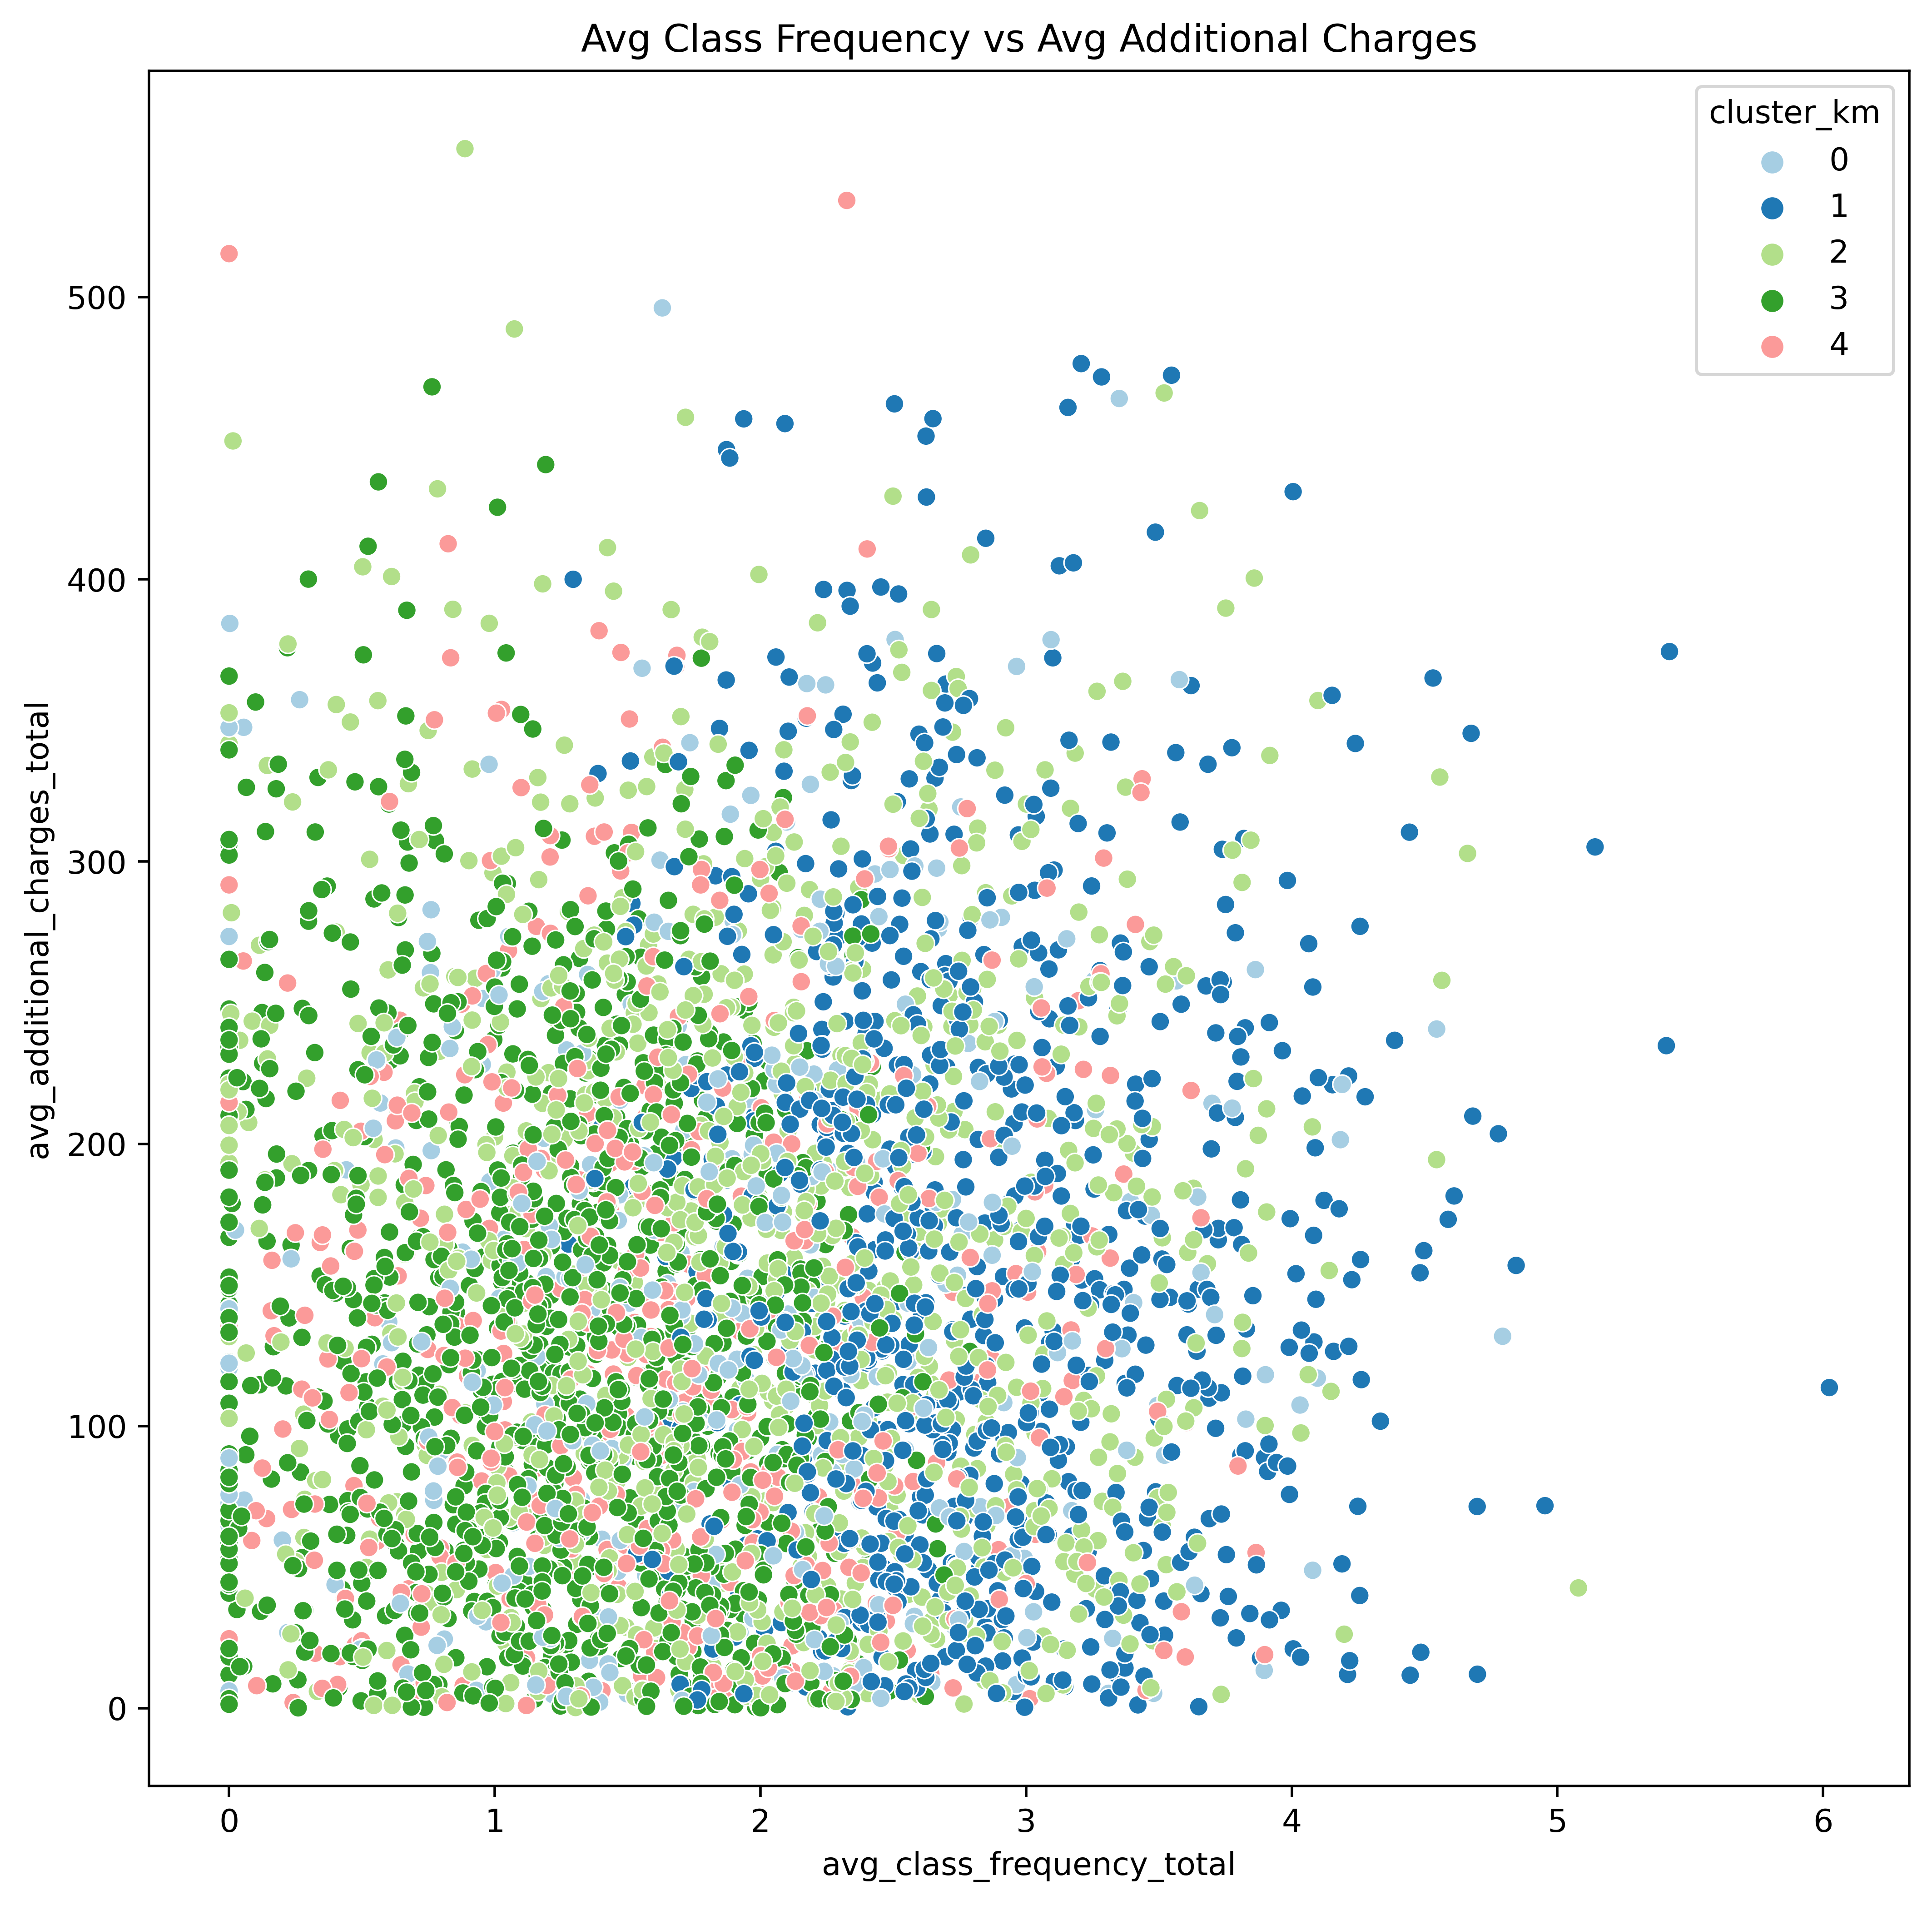

In [33]:
plt.figure(figsize=(10, 10), dpi = 500)
sns.scatterplot(x = churn_data['avg_class_frequency_total'], y = churn_data['avg_additional_charges_total'], hue=churn_data['cluster_km'], palette='Paired')
plt.title('Avg Class Frequency vs Avg Additional Charges')
plt.show()

É possível perceber o grande cruzamento existente entre a frequência de participação em aula e o aumento de gastos adicionais. Logo, estimular a ida de clientes mais vezes por semana na academia é lucrativo.

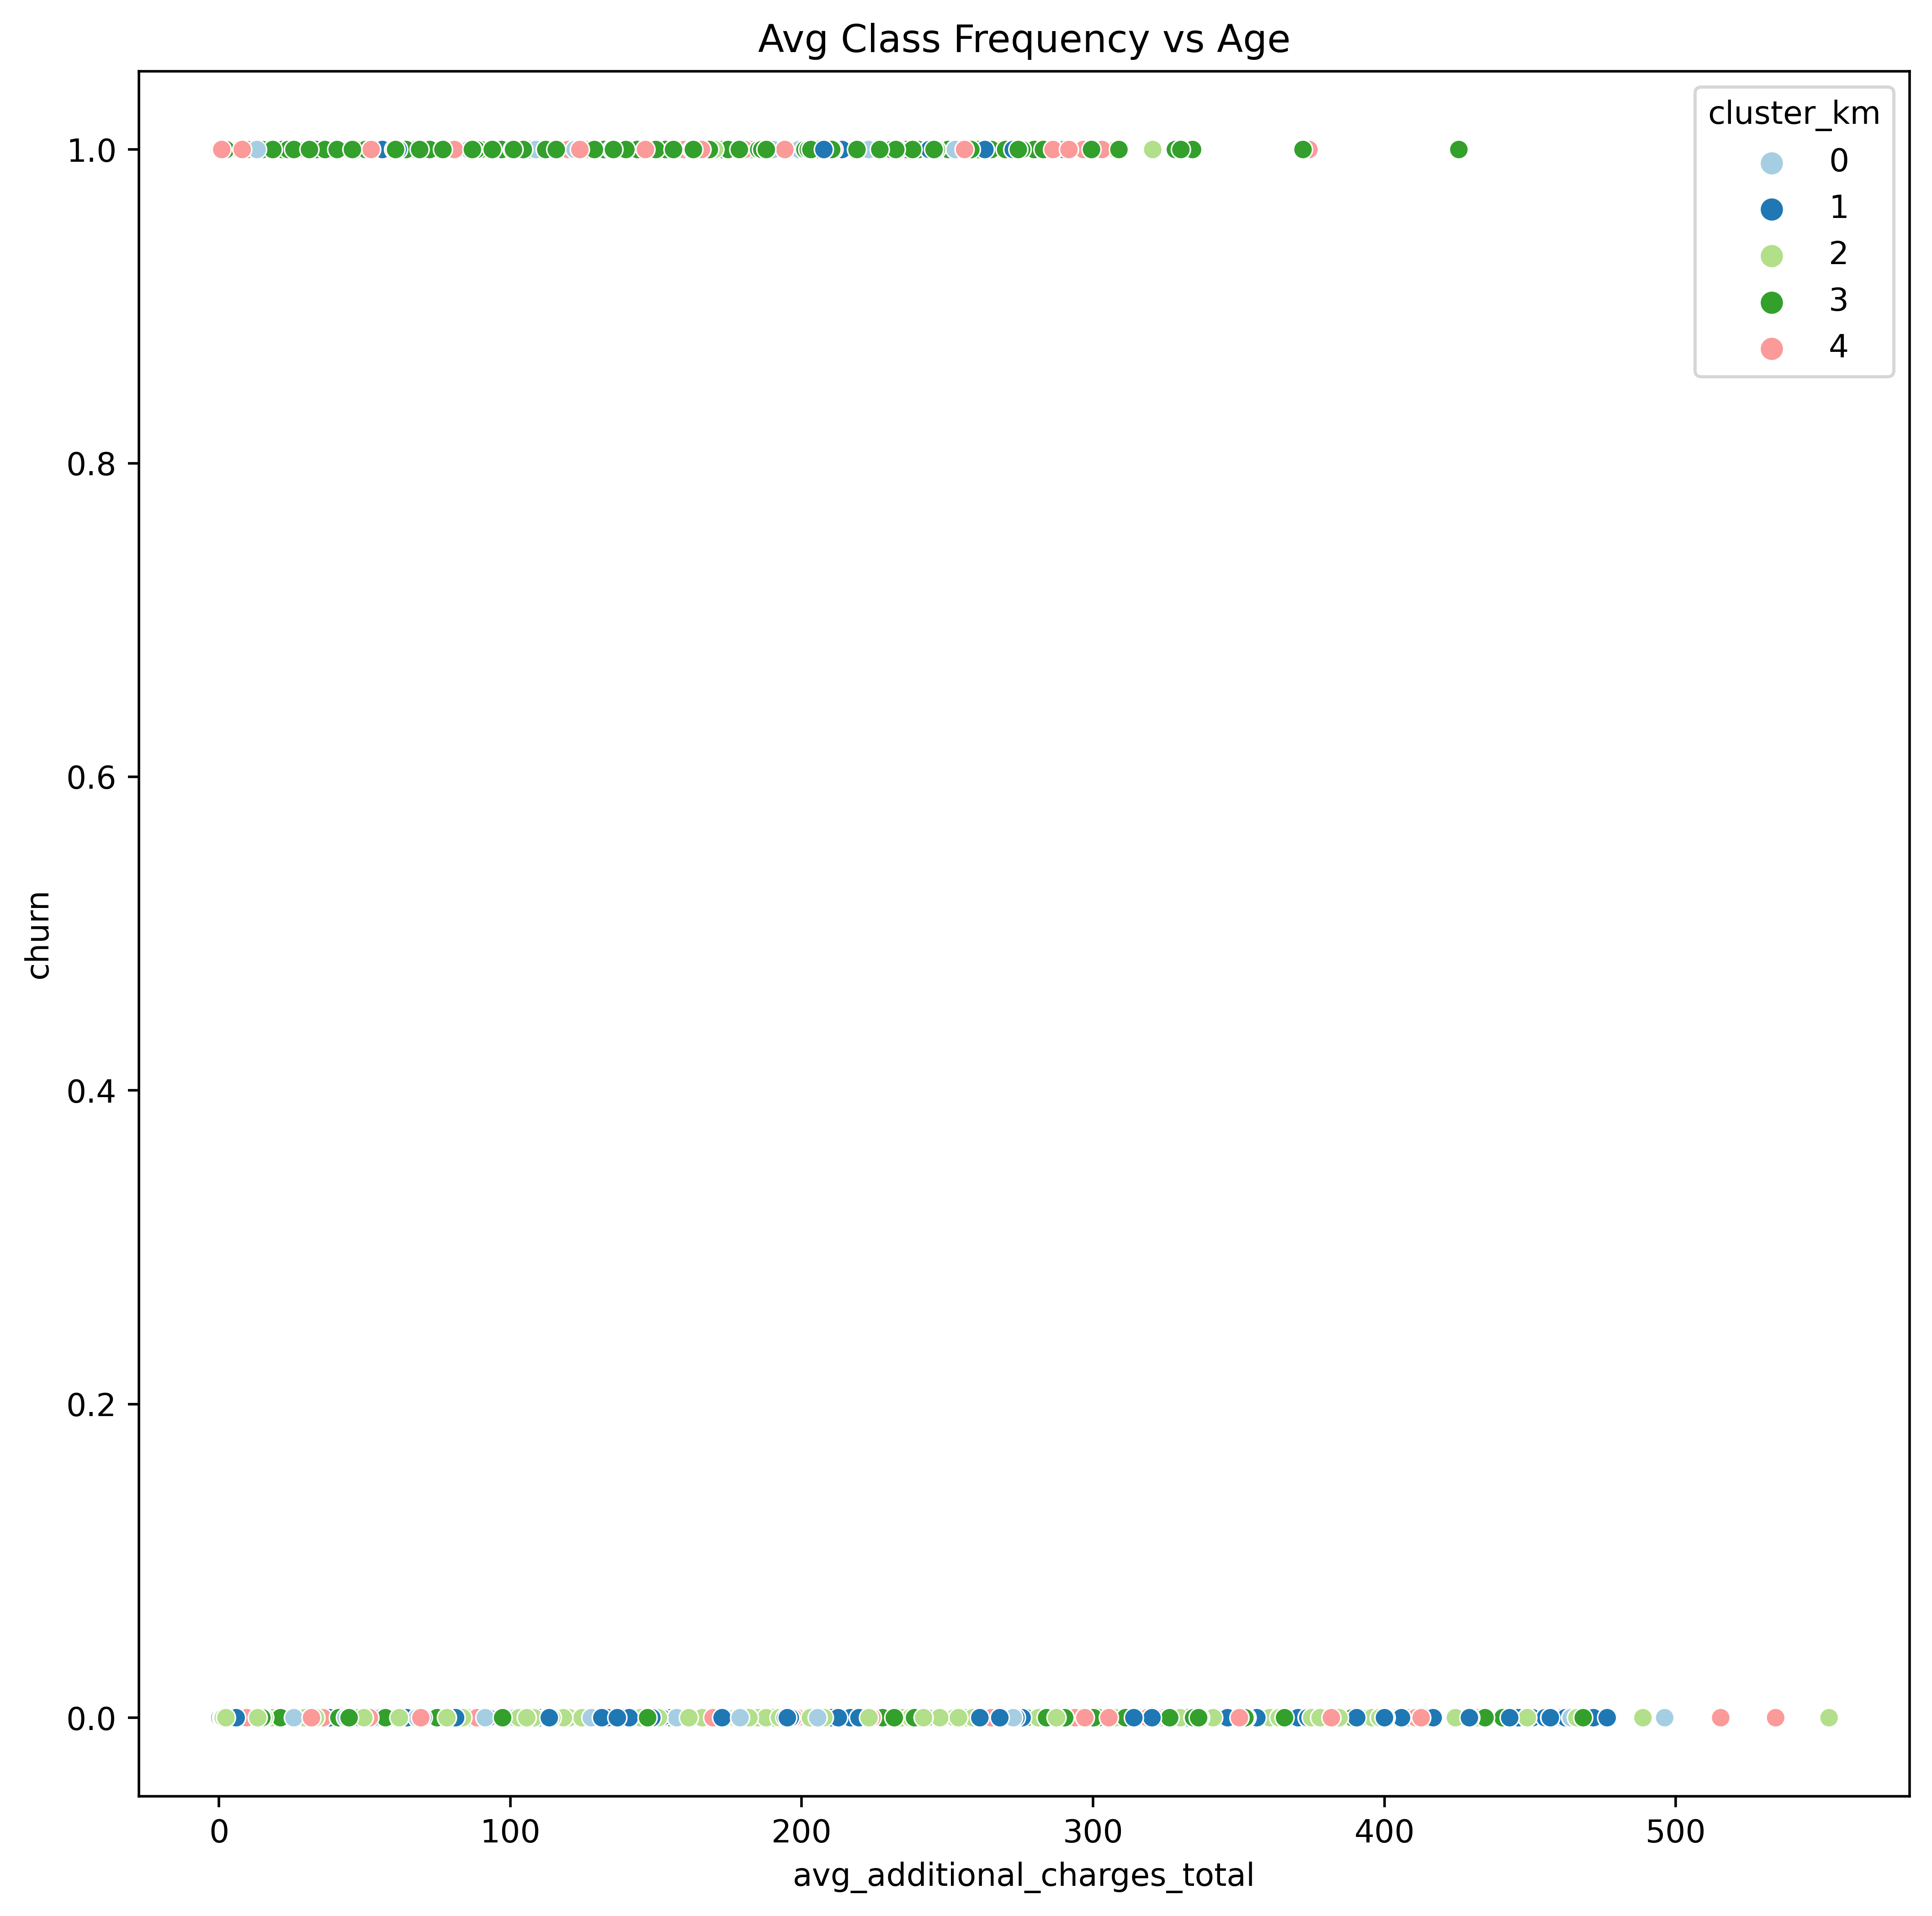

In [34]:
plt.figure(figsize=(10, 10), dpi = 500)
sns.scatterplot(x = churn_data['avg_additional_charges_total'], y = churn_data['churn'], hue=churn_data['cluster_km'], palette='Paired')
plt.title('Avg Class Frequency vs Age')
plt.show()

Não é lucrativo a academia perder clientes. É visível que clientes que não cancelam sua assinatura gastam muito mais do que os que cancelam. 

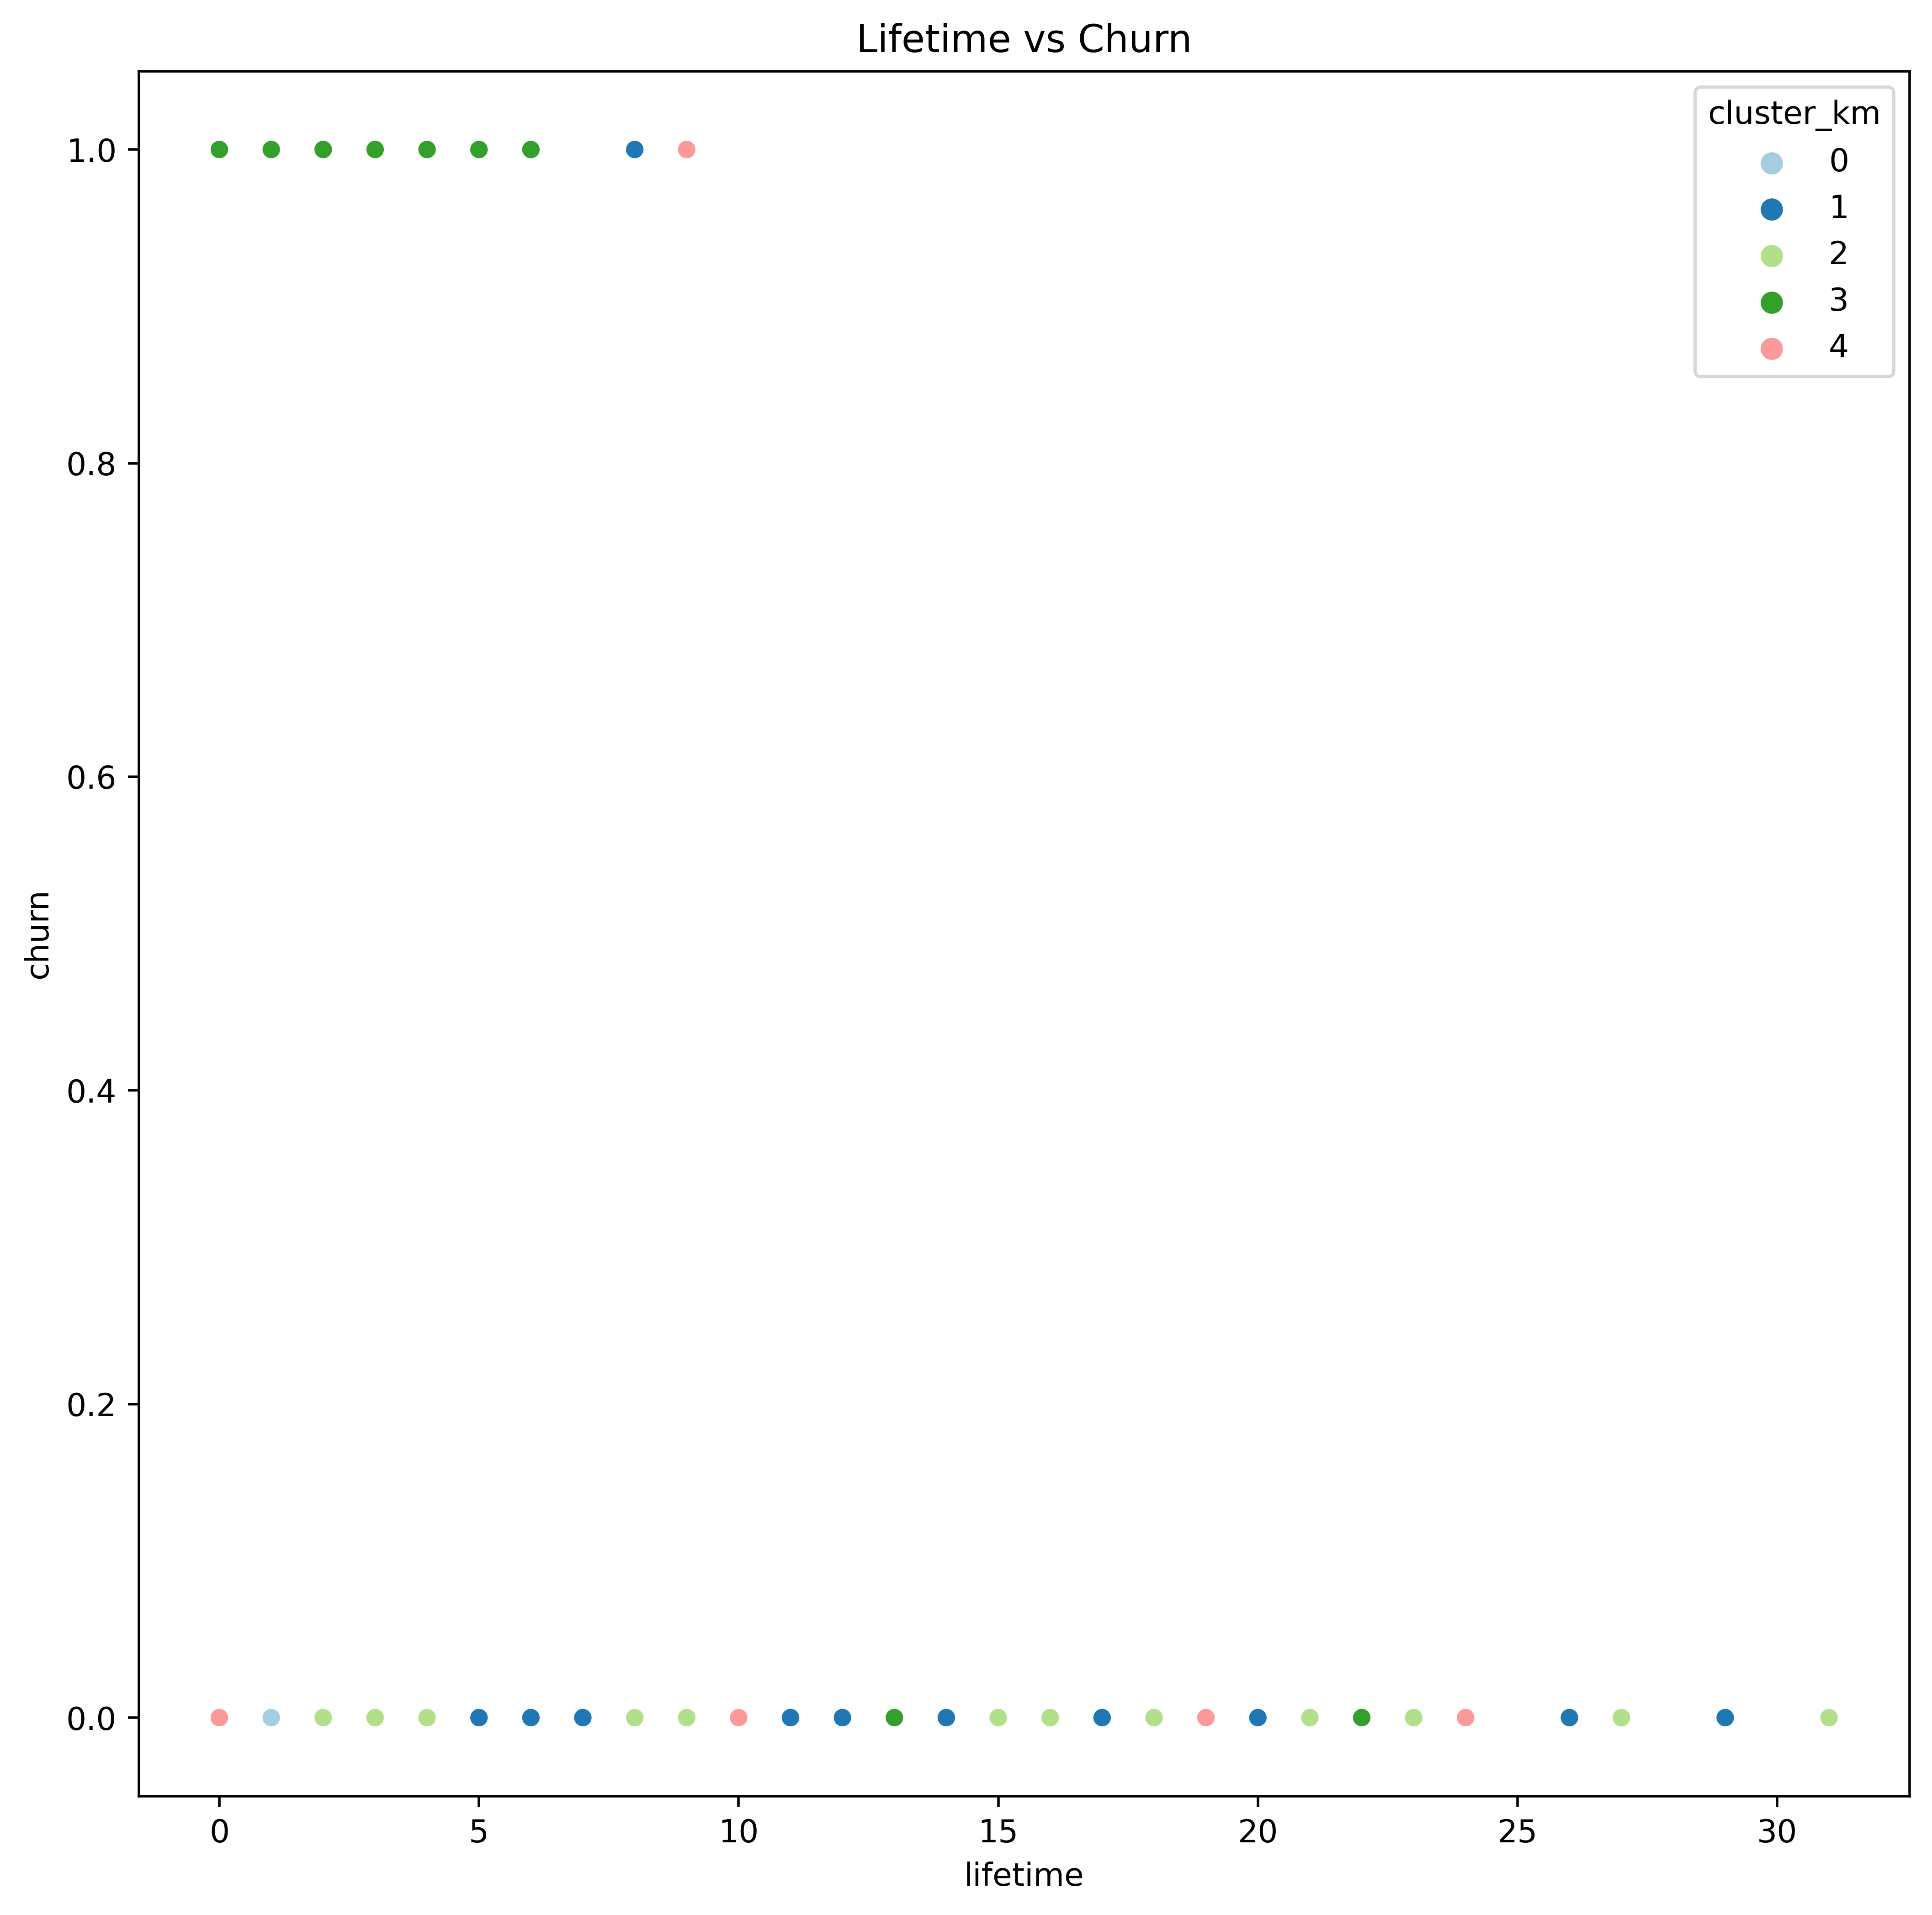

In [35]:
plt.figure(figsize=(10, 10), dpi = 500)
sns.scatterplot(x = churn_data['lifetime'], y = churn_data['churn'], hue=churn_data['cluster_km'], palette='Paired')
plt.title('Lifetime vs Churn')
plt.show()

Maior tempo de permanência na academia implica uma diminuição no cancelamento. Qualquer método que favorecer a renovação do contrato do cliente é válido e lucrativo a longo prazo. 

# 4 Conclusão

Através de algoritmos de machine learning (Regressão Logística e Random Forest) conseguimos prever quantos clientes irão cancelar seus contratos da academia nesse mês. Após uma análise minuciosa sobre qual algoritmo apresentava melhor resultado, e se a utilização da padronização implicava em uma melhoria dos testes, pudemos identificar que o algoritmo de Random Forest apresentava os melhores resultados ao apontar poucos alertas falsos. Esse algoritmo previu que 155 clientes irão cancelar suas assinaturas no mês corrente, enquanto 575 irão continuar. 

Além disso, através do agrupamento pudemos identificar características que implicam na saída de um cliente da academia ao dividi-los em clusters que mostravam essas características subdivididas. 

Vou listar 4 problemas encontrados e 4 estratégias de marketing e estrutura pra lidar com cada um deles:

    1) Clientes que moram longe possuem uma alta taxa de cancelamento: um dos agrupamentos apresentava um conjunto de clientes que não moravam próximos à academia. Esses clientes poderiam até estar satisfeitos com o serviço, mas a distância é um impeditivo muito grande. Assim, uma estratégia seria pensar na expansão da academia. Se esses clientes distantes estão vindo todos de um mesmo bairro, é possível que não exista uma academia adequada neste local. A instalação de uma nova academia capitalizaria esses clientes e provavelmente atrairia novos que não cogitaram se matricular por causa da distância
    
    2) Clientes insatisfeitos: o cluster 4 apresentava clientes com uma altíssima taxa de cancelamento. Esses clientes moravam próximos à academia, então algum outro fator foi o problema pra eles. Para identificar qual o motivo do cancelamento, seria interessante uma pesquisa de satisfação. A academia precisa encontrar qual o problema que eles estão tendo e o motivo do cancelamento. Se for um motivo técnico, como falta de aparelhos ou uma atividade específica, a academia pode buscar resolver e oferecer um novo plano pra esses clientes.
    
    3) Parcerias e promoções de amigos: o cluster 1 apresenta uma alta média de clientes que visitam a academia por possuírem parcerias de empresas ou terem sido indicados por amigos. Essa estratégia então está se apresentando eficiente, pois os clientes estão vindo. Porém, os gastos adicionais desse grupo são baixos, e o tempo de vida também. Claramente são clientes que gostam de promoções, então explorar estratégias promocionais são benéficas, como: contrato de 12 anos com desconto pra indicados; indique mais 10 amigos e ganhe 1 mês grátis; gaste um certo valor x adicional e ganhe novos benefícios. Para esse grupo, qualquer tipo de estratégia promocional onde o cliente sinta que está sendo beneficiado vai ser bem recebida.
    
    4) Clientes assíduos mas poucos fieis: O cluster 2 apresenta uma parcela de clientes motivados, que possuem vontade de realizar as atividades da academia, porém não estão com contratos longos. Alguma coisa fez com que esses clientes fizessem contratos curtos, e é passível de investigação. Talvez oferecer uma promoção de 12 meses faça com que esses clientes assinem um contrato longo. É visível que eles gostam do serviço, pois a taxa de cancelamento é baixa, então precisamos encontrar novas estratégias pra manter esses clientes por mais tempo possível. 
    
    5) O cluster 3 é o grupo fiel mais assíduo, com longos tempos de contratos. Esses clientes merecem atenção para encontrarmos quais foram os motivos que os fizeram assinar um contrato longo na nossa academia. Pesquisas de satisfação e recompensas são estratégias que podemos explorar pra verificar o que fazem esses clientes serem fieis e podemos utilizar esses parâmetros pra melhorar pontos da academia para os outros grupos.